<h1><center>Formula 1 Forecasting</center></h1>

## Table of Contents

**[Business Understanding](#business-understanding)**
   - [About Formula 1 Racing](#about)
   - [Objectives](#objectives)
   
**[Data Understanding](#data-understanding)**
  - [Import Libraries](#import-libraries)
  - [Import Data](#import-data)
  - [Lap Times](#lap-times)
  - [Pit Stops](#pit-stops)
  - [Qualifying](#qualifying)
  - [Races](#races)
  - [Results](#results)
  - [Sprint Results](#sprint-results)
  - [Status](#status) 
  
**[Data Preparation](#data-preparation)**
  - [Join - Lap Times & Races](#join-laptimes-races)
  - [Join - Lap_Times_Races and Pit Stops](#join-pitstops-laptimes)
  - [Join - Results & Status](#join-results-status)
  
**[Time Series Analysis](#ts-analysis)**
  - [Select Driver & Race](#driver-race)
  - [Outlier Analysis](#outlier-analysis) 
  - [Visualize Series](#visualize-verstappen)
  - [Verstappen vs Driver 844](#driver-comparison)
  - [Series Decomposition](#decomposition)
  - [Stationarity Tests](#stationarity-tests)
  - [Box Cox Transformation](#box-cox-transformation)
  - [Auto-Correlation Analysis](#autocorrelation-analysis)
  
**[Model Building & Evaluation](#modeling)**
   - [Train-Test Split](#train-test-split)
   
   - [Error Measurement](#error-measurement)
   
   - [Simple Exponential Smoothing](#ses)
      - [Baseline Model](#ses-baseline)
      - [Hyperparameter tuning](#ses-gs)
      
   - [Holt Exponential Smoothing](#holt)
      - [Baseline Model](#holt-baseline)
      - [Hyperparameter Tuning ](#holt-gs)

   - [Holt-Winters Exponential Smoothing](#holt-winters)
      - [Baseline Model](#holt-winters-baseline)
      - [Hyperparameter Tuning ](#holt-winters-gs)
   
   - [ARIMAX](#arimax)
      - [Baseline Model](#arimax-baseline)
      - [Hyperparameter Tuning](#arimax-gs)
   - [Model Comparison](#model-comparison)

**[Walk Forward Forecasts](#walk-forward)**
   - [SES - Walk Forward](#ses-walk-forward)
   - [Holt Winter's - Walk Forward](#holt-winters-walk-forward)
   - [ARIMAX - Walk Forward](#arimax-walk-forward)

**[Modeling Lap Times for Driver 844](#driver844)**
   - [SES - Grid Search](#ses-gs-844)
   - [ARIMAX - Grid Search](#holt-winters-gs-844)
   

**[Ideas for Improvement](#ideas)**

   
**[Discareded Models](#retired-models)**
   - [Moving Average](#ma)
   - [Simple Autoregression](#sar)      
   - [ARMA](#arma)
   - [SARMA](#sarma)
   - [ARIMA](#arima)
   - [SARMAX](#sarmax)

**[References](#references)**
   - [Formula One](#references-f1)
   - [Time Series](#references-ts)

<h2><a id="business-understanding">Business Understanding</a><h2>

 <h3><a id="about">About Formula One</a></h3>
 A summary of everything I learnt about Formula 1:

- Formula 1 started in 1950


- The Constructor's champsionship started in 1958


- From 1950 to 2023, there have been 1101 races in total. 34 different drivers have been crowned world drivers champion across 74 Formula 1 seasons


- A the end of each year, there are Championships for drivers based on races won & a Constructor championship given to constructors based on points for both drivers


- In 2024, there are 24 grand prix. Races are generally held March to November.


- 10 teams consisting of 20 drivers compete at every event


- Each event lasts 3 Days. Friday-2 Practices, Saturday - 1 Practice + 3 Qualifying Rounds, Sunday - Grand Prix 


- Exact race should be a total distance of ~307 kms. The number of laps vary by each circuit's distance so you can expect laps to vary 40-80


- It takes 80-100 minutes to complete a full race.


- Grid positions at start of Grand Prix is based on performance in qualifying rounds respectively for Grand Prix & Sprint 


- Sprints are races at 1/3rd of the Grand Prix distance and have their own qualifying shootouts (replaces FP2 on Friday) & Sprint (replaces FP3) on Saturday followed by Qualifier and finally Grand Prix on Sunday.


- In F1 if an accident or inclement weather (typically, heavy rain) or slippery surface (oil or water) prevents normal racing from continuing safely, the Race Director will call for a "safety car" period. This is a yellow or red-stripped flag so drivers will slow down or a red flag which means they'll have to pause and restart the race based on where everyone was positioned before the flag. 


- There are 138 official reasons for not completing a race (per status spreadsheet)


- Shortest pit stop of all times - 1.8 seconds. Even 100 milliseconds can make a difference between rank one and two and so on. so pit stops have to very fast and the pit team practices thousands of times to minimize pit stop time.


- One pit stop per race is MANDATORY but they are also part of a race strategy. Pit stopping can add to your race time BUT a fresh set of tyres can speed up your car a lot. Sometimes drivers undecut (stop earlier in the race to get faster early on) or overcut (stop later than competitors so they get clean air to move ahead while competitor does a stop)



- Lap times can be impacted less by the driver's performance which may be pretty consistent among top racers and more by the race strategy (tire type, pit stops, overcut/undercut etc.) and unforeseen issues such as penalties and safety car periods.


- Cars get faster after pit stops because new tyres means more speed. Pit stops are a part of race strategy and planned well in advance, except in case of penalties. 


- Cars also get faster in later laps because they lose fuel so are lighter. Re-fuelling is not allowed during pit stops.

 <h3><a id="objectives">Objectives</a></h3>

Note from Zapata:

In a nutshell, we are investigating similar models to be able to predict the lap times of competitor cars (with respect to a selected reference car) a few laps into the future to be able to make live recommendations on whether a car should perform a passing maneuver on another car soon, anticipate competitor cars' fuel consumption and race times to possibly adjust a pit stop strategy, help calculate the probability for a collision of two cars soon etc. Goal is to provide a competitive advantage for a client with a team by adding this predictive capability to enhance their decision making for their race strategy during a live race.

<h2><a id="data-understanding">Data Understanding</a></h2>

Based on Data Dictionary - https://docs.google.com/spreadsheets/d/1f3GJVgvQ_QMW7PU3DwgMF-xkxSpjyVOgURRHsslIQE4/edit?usp=sharing

<h3><a id="import-libraries">Import Libraries</a></h3>

In [1]:
import os
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#stats & ML
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose #time series decomposition
from statsmodels.tsa.stattools import kpss, adfuller #stationary tests
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf #autocorrelation

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

#metrics
from sklearn.metrics import mean_squared_error

In [2]:
#Configure notebook

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set Parameters for Displaying data
pd.options.display.max_info_columns = 300
pd.set_option('display.max_columns', 120)
pd.options.display.max_rows = 300

np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.4f}'.format

# #InteractiveShell.ast_node_interactivity = "all"
sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 10]


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

#getting profiling to work using pip installation
# import sys
# !{sys.executable} -m pip install -U ydata-profiling[notebook]
# !jupyter nbextension enable --py widgetsnbextension

<h3><a id="import-data">Import Data</a></h3>

In [3]:
df_lap_times = pd.read_csv('data/lap_times.csv')
df_pit_stops = pd.read_csv('data/pit_stops.csv')
df_qualifying_results = pd.read_csv('data/qualifying.csv')
df_races = pd.read_csv('data/races.csv')
df_results = pd.read_csv('data/results.csv')
df_sprint_results = pd.read_csv('data/sprint_results.csv')
df_status = pd.read_csv('data/status.csv')

<h3><a id="lap-times">Lap Times</a></h3>

Each row is a lap per race per driver

In [4]:
df_lap_times.sample(3)
df_lap_times.describe()
df_lap_times.info()

,raceId,driverId,lap,position,time,milliseconds
176112,189,55,7,8,1:44.446,104446
192086,171,48,36,10,1:28.548,88548
539695,1099,807,4,13,1:37.593,97593


,raceId,driverId,lap,position,milliseconds
count,551742.0000,551742.0000,551742.0000,551742.0000,551742.0000
mean,564.8785,296.9188,29.9902,9.6587,95706.2057
std,425.8831,377.9359,18.4204,5.5380,74786.0462
min,1.0000,1.0000,1.0000,1.0000,55404.0000
25%,131.0000,15.0000,14.0000,5.0000,81993.0000
50%,846.0000,39.0000,29.0000,9.0000,90673.0000
75%,976.0000,817.0000,44.0000,14.0000,102243.0000
max,1110.0000,858.0000,87.0000,24.0000,7507547.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551742 entries, 0 to 551741
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   raceId        551742 non-null  int64 
 1   driverId      551742 non-null  int64 
 2   lap           551742 non-null  int64 
 3   position      551742 non-null  int64 
 4   time          551742 non-null  object
 5   milliseconds  551742 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 25.3+ MB


In [5]:
#How many null values
df_lap_times.isnull().sum().sort_values(ascending=False)

milliseconds    0
time            0
position        0
lap             0
driverId        0
raceId          0
dtype: int64

>Observation: Lap Times has no null-data. I noticed thought that 'time' column which is "hrs:min:1/10 of sec" is not needed since we measure milliseconds anyway.

In [6]:
df_lap_times = df_lap_times.drop(['time'],axis=1)

<h3><a id="pit-stops">Pit Stops</a></h3>

Includes all the laps in which pit stops happened and the pit stop times for each car. Each row is a pitted lap, per race per driver

In [7]:
df_pit_stops.sample(3)
df_pit_stops.describe()
df_pit_stops.info()

,raceId,driverId,stop,lap,time,duration,milliseconds
2535,888,820,1,8,14:17:26,21.021,21021
4680,950,825,1,4,14:10:58,23.158,23158
6061,982,1,4,29,21:10:11,28.466,28466


,raceId,driverId,stop,lap,milliseconds
count,10089.0000,10089.0000,10089.0000,10089.0000,10089.0000
mean,962.7740,523.9989,1.7597,25.3120,75348.6334
std,81.1444,389.6986,0.9163,14.7298,278858.8458
min,841.0000,1.0000,1.0000,1.0000,12897.0000
25%,888.0000,18.0000,1.0000,13.0000,21914.0000
50%,958.0000,815.0000,2.0000,25.0000,23570.0000
75%,1035.0000,831.0000,2.0000,36.0000,26202.0000
max,1110.0000,858.0000,6.0000,78.0000,3069017.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10089 entries, 0 to 10088
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   raceId        10089 non-null  int64 
 1   driverId      10089 non-null  int64 
 2   stop          10089 non-null  int64 
 3   lap           10089 non-null  int64 
 4   time          10089 non-null  object
 5   duration      10089 non-null  object
 6   milliseconds  10089 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 551.9+ KB


In [8]:
#How many null values
df_pit_stops.isnull().sum().sort_values(ascending=False)

milliseconds    0
duration        0
time            0
lap             0
stop            0
driverId        0
raceId          0
dtype: int64

In [9]:
#drop duration since we have data in millseconds
df_pit_stops = df_pit_stops.drop('duration',axis=1)
df_pit_stops.sample(1)

,raceId,driverId,stop,lap,time,milliseconds
7895,1044,8,2,30,14:09:48,31356


In [10]:
#convert 'time' to datetime object
df_pit_stops['time'] = pd.to_datetime(df_pit_stops['time'], format='%H:%M:%S')
df_pit_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10089 entries, 0 to 10088
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   raceId        10089 non-null  int64         
 1   driverId      10089 non-null  int64         
 2   stop          10089 non-null  int64         
 3   lap           10089 non-null  int64         
 4   time          10089 non-null  datetime64[ns]
 5   milliseconds  10089 non-null  int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 473.0 KB


>**Warning:** Dropped wall clock 'time' of pit stop as it's unlikely to be useful based on a review of other dataframes too. It may have been useful if we did not have the lap count which is what we'll use for the time series. Including a warning in case I need to revisit this

In [11]:
#Deleting wall clock 'time' of pit stop
df_pit_stops = df_pit_stops.drop('time',axis=1)

<h3><a id="races">Races</a></h3>

Meta data for events (name, year, wiki link etc.)

In [12]:
df_races.sample(3)
df_races.info()
df_races.describe()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
635,636,1971,5,34,French Grand Prix,1971-07-04,\N,http://en.wikipedia.org/wiki/1971_French_Grand...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
649,650,1970,8,10,German Grand Prix,1970-08-02,\N,http://en.wikipedia.org/wiki/1970_German_Grand...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
848,850,2011,10,20,German Grand Prix,2011-07-24,12:00:00,http://en.wikipedia.org/wiki/2011_German_Grand...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   raceId       1101 non-null   int64 
 1   year         1101 non-null   int64 
 2   round        1101 non-null   int64 
 3   circuitId    1101 non-null   int64 
 4   name         1101 non-null   object
 5   date         1101 non-null   object
 6   time         1101 non-null   object
 7   url          1101 non-null   object
 8   fp1_date     1101 non-null   object
 9   fp1_time     1101 non-null   object
 10  fp2_date     1101 non-null   object
 11  fp2_time     1101 non-null   object
 12  fp3_date     1101 non-null   object
 13  fp3_time     1101 non-null   object
 14  quali_date   1101 non-null   object
 15  quali_time   1101 non-null   object
 16  sprint_date  1101 non-null   object
 17  sprint_time  1101 non-null   object
dtypes: int64(4), object(14)
memory usage: 155.0+ KB


,raceId,year,round,circuitId
count,1101.0000,1101.0000,1101.0000,1101.0000
mean,553.3551,1992.0209,8.4941,23.7003
std,321.4258,20.2964,5.0811,19.3460
min,1.0000,1950.0000,1.0000,1.0000
25%,276.0000,1976.0000,4.0000,9.0000
50%,551.0000,1994.0000,8.0000,18.0000
75%,826.0000,2010.0000,12.0000,34.0000
max,1120.0000,2023.0000,22.0000,80.0000


>**Observations**: We likely don't need the exact date, just the year for filtering later on. Also, the fp1, fp2 & fp3 columns might have null values

In [13]:
#convert to datetime object
df_races['year'] = pd.to_datetime(df_races['date']).dt.year
df_races = df_races.drop('date',axis=1)

In [14]:
#What percentage of these columns are null (\N) values?
null_values = df_races[(df_races.fp1_date=='\\N') & (df_races.sprint_time=='\\N') & (df_races.quali_date=='\\N')].shape[0]
print(null_values/df_races.shape[0]*100, "%")


94.00544959128065 %


In [15]:
#where are the non-null values?
df_races.tail(5)

,raceId,year,round,circuitId,name,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
1096,1116,2023,18,69,United States Grand Prix,19:00:00,https://en.wikipedia.org/wiki/2023_United_Stat...,2023-10-20,17:30:00,2023-10-21,18:00:00,\N,\N,2023-10-20,21:00:00,2023-10-21,22:00:00
1097,1117,2023,19,32,Mexico City Grand Prix,20:00:00,https://en.wikipedia.org/wiki/2023_Mexico_City...,2023-10-27,18:30:00,2023-10-27,22:00:00,2023-10-28,17:30:00,2023-10-28,21:00:00,\N,\N
1098,1118,2023,20,18,São Paulo Grand Prix,17:00:00,https://en.wikipedia.org/wiki/2023_S%C3%A3o_Pa...,2023-11-03,14:30:00,2023-11-04,14:30:00,\N,\N,2023-11-03,18:00:00,2023-11-04,18:30:00
1099,1119,2023,21,80,Las Vegas Grand Prix,06:00:00,https://en.wikipedia.org/wiki/2023_Las_Vegas_G...,2023-11-17,04:30:00,2023-11-17,08:00:00,2023-11-18,04:30:00,2023-11-18,08:00:00,\N,\N
1100,1120,2023,22,24,Abu Dhabi Grand Prix,13:00:00,https://en.wikipedia.org/wiki/2023_Abu_Dhabi_G...,2023-11-24,09:30:00,2023-11-24,13:00:00,2023-11-25,10:30:00,2023-11-25,14:00:00,\N,\N


>**Observation:** The columns fp1_date, fp1_time, fp2_date, fp2_time, fp3_date, fp3_time, quali_date, quali_time, sprint_date, sprint_time are roughly 94% filled with '\N' values except for the last few years of data. The data dictionary does not define these columns too so it makes sense to drop them.

>**Warning:** There must be some valuable info in here that likely started getting recorded in the database in the last few years so we're intentionally mising out on them. So once the data dictionary is updated, be sure to revisit these variables.

In [16]:
df_races = df_races.drop(['fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date','quali_time', 'sprint_date', 'sprint_time'],axis=1)
df_races.sample(1)

,raceId,year,round,circuitId,name,time,url
450,451,1984,16,27,Portuguese Grand Prix,\N,http://en.wikipedia.org/wiki/1984_Portuguese_G...


In [17]:
#What percentage of time are null (\N) values?
null_time = df_races[df_races.time=='\\N'].shape[0]
print(null_time/df_races.shape[0]*100, "%")


66.39418710263398 %


In [18]:
#When is it non-null?
df_races[df_races.time!='\\N'].sample(10)

,raceId,year,round,circuitId,name,time,url
1005,1018,2019,9,70,Austrian Grand Prix,13:10:00,http://en.wikipedia.org/wiki/2019_Austrian_Gra...
967,980,2017,12,13,Belgian Grand Prix,12:00:00,http://en.wikipedia.org/wiki/2017_Belgian_Gran...
1018,1031,2020,1,70,Austrian Grand Prix,13:10:00,http://en.wikipedia.org/wiki/2020_Austrian_Gra...
1077,1095,2022,21,18,Brazilian Grand Prix,18:00:00,http://en.wikipedia.org/wiki/2022_Brazilian_Gr...
1070,1087,2022,14,13,Belgian Grand Prix,13:00:00,http://en.wikipedia.org/wiki/2022_Belgian_Gran...
1095,1115,2023,17,78,Qatar Grand Prix,14:00:00,https://en.wikipedia.org/wiki/2023_Qatar_Grand...
859,861,2012,2,2,Malaysian Grand Prix,08:00:00,http://en.wikipedia.org/wiki/2012_Malaysian_Gr...
909,912,2014,13,14,Italian Grand Prix,12:00:00,http://en.wikipedia.org/wiki/2014_Italian_Gran...
1038,1051,2021,20,78,Qatar Grand Prix,14:00:00,http://en.wikipedia.org/wiki/2021_Qatar_Grand_...
79,80,2005,10,8,French Grand Prix,14:00:00,http://en.wikipedia.org/wiki/2005_French_Grand...


>**Observation:** 66% of the race start 'time' values are missing, quite randomly. I also don't believe that it offers much value for lap time prediction so let's drop it for now except if it can be used to include weather conditions into the model but given that F1 races are all over the world in a variety of climates, it's unlikely to be a useful input.

In [19]:
df_races = df_races.drop('time', axis=1)
df_races.sample(1)

,raceId,year,round,circuitId,name,url
527,528,1978,2,36,Brazilian Grand Prix,http://en.wikipedia.org/wiki/1978_Brazilian_Gr...


<h3><a id="qualifying">Qualifying</a></h3>

All the lap times of all the cars obtained during qualifying races

In [20]:
df_qualifying_results.sample(3)

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
6624,6647,944,8,6,7,5,1:12.185,1:12.243,1:12.144
3757,3759,355,1,1,2,2,1:40.335,1:40.119,1:39.425
4909,4912,857,155,15,16,18,1:27.876,\N,\N


<h3><a id="results">Results</a></h3>

Each row has the result for each driver per grand prix race 

In [21]:
df_results.sample(3)
df_results.describe()
df_results.info()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
25565,25571,1082,839,214,31,7,6,6,6,8.0000,70,+23.890,5805647,62,9,1:17.110,203.600,1
18992,18993,789,475,105,7,1,\N,R,12,1.0000,94,\N,\N,\N,\N,\N,\N,109
24513,24519,1025,842,5,10,16,14,14,14,0.0000,53,+1:10.076,5689068,51,14,1:38.606,213.504,1


,resultId,raceId,driverId,constructorId,grid,positionOrder,points,laps,statusId
count,26080.0000,26080.0000,26080.0000,26080.0000,26080.0000,26080.0000,26080.0000,26080.0000,26080.0000
mean,13041.3727,536.6957,266.2776,49.0597,11.1676,12.8541,1.9066,46.0767,17.4761
std,7530.0084,303.0346,272.5816,60.2211,7.2328,7.7001,4.2197,29.7261,26.1300
min,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000
25%,6520.7500,294.7500,57.0000,6.0000,5.0000,6.0000,0.0000,22.0000,1.0000
50%,13040.5000,519.0000,163.0000,25.0000,11.0000,12.0000,0.0000,53.0000,10.0000
75%,19560.2500,791.0000,364.0000,58.2500,17.0000,18.0000,2.0000,66.0000,14.0000
max,26085.0000,1110.0000,858.0000,214.0000,34.0000,39.0000,50.0000,200.0000,141.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26080 entries, 0 to 26079
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         26080 non-null  int64  
 1   raceId           26080 non-null  int64  
 2   driverId         26080 non-null  int64  
 3   constructorId    26080 non-null  int64  
 4   number           26080 non-null  object 
 5   grid             26080 non-null  int64  
 6   position         26080 non-null  object 
 7   positionText     26080 non-null  object 
 8   positionOrder    26080 non-null  int64  
 9   points           26080 non-null  float64
 10  laps             26080 non-null  int64  
 11  time             26080 non-null  object 
 12  milliseconds     26080 non-null  object 
 13  fastestLap       26080 non-null  object 
 14  rank             26080 non-null  object 
 15  fastestLapTime   26080 non-null  object 
 16  fastestLapSpeed  26080 non-null  object 
 17  statusId    

<h3><a id="sprint-results">Sprint Results</a></h3>

Result for qualifying races (combined) per Driver per race

In [22]:
df_sprint_results.sample(3)
df_sprint_results.describe()
df_sprint_results.info()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,fastestLapTime,statusId
156,157,1107,856,213,21,14,17,17,17,0,24,+1:05.617,1892347,22,1:11.701,1
17,18,1061,854,210,47,19,18,18,18,0,17,+1:08.213,1606639,15,1:32.567,1
104,105,1095,815,9,11,9,5,5,5,4,24,+11.855,1823162,5,1:14.699,1


,resultId,raceId,driverId,constructorId,number,grid,positionOrder,points,laps,statusId
count,180.0000,180.0000,180.0000,180.0000,180.0000,180.0000,180.0000,180.0000,180.0000,180.0000
mean,90.5000,1085.6667,714.0889,95.5000,27.5500,10.1000,10.5000,1.3000,19.2167,3.9833
std,52.1057,17.3624,298.1128,88.3596,24.2739,5.8616,5.7824,2.3180,5.4693,17.6621
min,1.0000,1061.0000,1.0000,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000
25%,45.7500,1071.0000,817.0000,6.0000,10.0000,5.0000,5.7500,0.0000,17.0000,1.0000
50%,90.5000,1084.0000,840.0000,84.0000,20.0000,10.0000,10.5000,0.0000,21.0000,1.0000
75%,135.2500,1101.0000,847.0000,210.0000,44.0000,15.0000,15.2500,2.0000,24.0000,1.0000
max,180.0000,1110.0000,858.0000,214.0000,99.0000,20.0000,20.0000,8.0000,24.0000,130.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   resultId        180 non-null    int64 
 1   raceId          180 non-null    int64 
 2   driverId        180 non-null    int64 
 3   constructorId   180 non-null    int64 
 4   number          180 non-null    int64 
 5   grid            180 non-null    int64 
 6   position        180 non-null    object
 7   positionText    180 non-null    object
 8   positionOrder   180 non-null    int64 
 9   points          180 non-null    int64 
 10  laps            180 non-null    int64 
 11  time            180 non-null    object
 12  milliseconds    180 non-null    object
 13  fastestLap      180 non-null    object
 14  fastestLapTime  180 non-null    object
 15  statusId        180 non-null    int64 
dtypes: int64(10), object(6)
memory usage: 22.6+ KB


In [23]:
#Are sprint results a subet of the results dataframe?
df_sprint_results_not_in_df_results = df_sprint_results[~df_sprint_results.raceId.isin(df_results.raceId)]
df_sprint_results_not_in_df_results

#check using resultId
df_sprint_results_not_in_df_results2 = df_sprint_results[~df_sprint_results.resultId.isin(df_results.resultId)]
df_sprint_results_not_in_df_results2

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,fastestLapTime,statusId


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,fastestLapTime,statusId


In [24]:
df_sprint_results_not_in_df_results3 = df_sprint_results[df_sprint_results.resultId.isin(df_results.resultId)]
df_sprint_results_not_in_df_results3.shape

(180, 16)

In [25]:
#Verifying that the no. of rows is sprint_results is the same as thos with the sprint results' count of rows?
df_sprint_results_in_df_results = df_sprint_results[df_sprint_results.raceId.isin(df_results.raceId)]
df_sprint_results_in_df_results.shape

(180, 16)

In [26]:
#are the columns identical too?
columns_not_in_df_results = df_sprint_results.columns[~df_sprint_results.columns.isin(df_results.columns)]
columns_not_in_df_results

Index([], dtype='object')

>**Observation**: So Sprint Results is merely a subset of the Results table. We could maybe use this information later.

<h3><a id="status">Status</a></h3>

A list of reasons (a.k.a statuses) for a car retiring from or not completing an event

In [27]:
df_status.sample(3)
df_status.info()
df_status.describe()

,statusId,status
125,126,Supercharger
123,124,+19 Laps
20,21,Radiator


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   statusId  139 non-null    int64 
 1   status    139 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


,statusId
count,139.0000
mean,71.2374
std,41.0924
min,1.0000
25%,35.5000
50%,72.0000
75%,106.5000
max,141.0000


<h3><a id="data-preparation">Data Preparation</a></h3>

Here we will focus on prepare datasets by joining tables and filtering out relevant information

<h3><a id="join-laptimes-races">Join Lap Times and Races</a></h3>

This will bring race info into our laps time series dataset

In [28]:
#Join on raceId? 
df_races.raceId.nunique()
df_races.shape
df_lap_times.raceId.nunique()
df_lap_times.shape

1101

(1101, 6)

510

(551742, 5)

In [29]:
# Find raceId values only in df_races
raceId_only_in_races = df_races[~df_races['raceId'].isin(df_lap_times['raceId'])]
raceId_only_in_races.shape
raceId_only_in_races.sample(5)

(591, 6)

,raceId,year,round,circuitId,name,url
801,802,1954,4,55,French Grand Prix,http://en.wikipedia.org/wiki/1954_French_Grand...
317,318,1991,14,4,Spanish Grand Prix,http://en.wikipedia.org/wiki/1991_Spanish_Gran...
589,590,1974,1,25,Argentine Grand Prix,http://en.wikipedia.org/wiki/1974_Argentine_Gr...
701,702,1965,4,51,French Grand Prix,http://en.wikipedia.org/wiki/1965_French_Grand...
524,525,1979,14,7,Canadian Grand Prix,http://en.wikipedia.org/wiki/1979_Canadian_Gra...


>**Observation**: About 60% of the races have no corresponding lap times data. The missing information is from the early years which is understable. Let's do a left join that favors lap time since its what we care about the most for lap time prediction 

In [30]:
#join lap times and races
df_laptimes_races = pd.merge(df_lap_times, df_races, how='left', left_on=['raceId'], right_on=['raceId'])
df_laptimes_races = df_laptimes_races.reset_index(drop=True)

#let's check it out
df_laptimes_races.sample(3)
df_laptimes_races.info()

,raceId,driverId,lap,position,milliseconds,year,round,circuitId,name,url
110746,945,3,5,1,107188,2015,19,24,Abu Dhabi Grand Prix,http://en.wikipedia.org/wiki/2015_Abu_Dhabi_Gr...
75364,903,817,27,4,103892,2014,4,17,Chinese Grand Prix,http://en.wikipedia.org/wiki/2014_Chinese_Gran...
138411,217,77,5,10,81641,1997,11,11,Hungarian Grand Prix,http://en.wikipedia.org/wiki/1997_Hungarian_Gr...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551742 entries, 0 to 551741
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   raceId        551742 non-null  int64 
 1   driverId      551742 non-null  int64 
 2   lap           551742 non-null  int64 
 3   position      551742 non-null  int64 
 4   milliseconds  551742 non-null  int64 
 5   year          551742 non-null  int64 
 6   round         551742 non-null  int64 
 7   circuitId     551742 non-null  int64 
 8   name          551742 non-null  object
 9   url           551742 non-null  object
dtypes: int64(8), object(2)
memory usage: 42.1+ MB


<h3><a id="join-pitstops-laptimes">Join Lap-Times-Races and Pit Stops</a></h3>

This will bring pit stop info into the laps time series (joined with races already) dataset

In [31]:
#rename pit stops column so they make sense after merge
df_pit_stops = df_pit_stops.rename(columns={
    'stop': 'stop_count',
    'milliseconds': 'pit_stop_milliseconds'
})

In [32]:
#join lap times and races
df_laptimes_pitstops = pd.merge(df_laptimes_races, df_pit_stops, how='left', left_on=['raceId', 'driverId', 'lap'], right_on=['raceId', 'driverId', 'lap'])
# df_laptimes_pit_stops = df_laptimes_pit_stops.reset_index(drop=True)

#let's check it out
df_laptimes_pitstops.sample(3)
df_laptimes_pitstops.info()

,raceId,driverId,lap,position,milliseconds,year,round,circuitId,name,url,stop_count,pit_stop_milliseconds
502641,1062,839,17,1,84113,2021,11,11,Hungarian Grand Prix,http://en.wikipedia.org/wiki/2021_Hungarian_Gr...,nan,nan
32240,866,154,67,2,77956,2012,7,7,Canadian Grand Prix,http://en.wikipedia.org/wiki/2012_Canadian_Gra...,nan,nan
500461,1060,815,70,5,68579,2021,9,70,Austrian Grand Prix,http://en.wikipedia.org/wiki/2021_Austrian_Gra...,nan,nan


<class 'pandas.core.frame.DataFrame'>
Int64Index: 551742 entries, 0 to 551741
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   raceId                 551742 non-null  int64  
 1   driverId               551742 non-null  int64  
 2   lap                    551742 non-null  int64  
 3   position               551742 non-null  int64  
 4   milliseconds           551742 non-null  int64  
 5   year                   551742 non-null  int64  
 6   round                  551742 non-null  int64  
 7   circuitId              551742 non-null  int64  
 8   name                   551742 non-null  object 
 9   url                    551742 non-null  object 
 10  stop_count             10089 non-null   float64
 11  pit_stop_milliseconds  10089 non-null   float64
dtypes: float64(2), int64(8), object(2)
memory usage: 54.7+ MB


In [33]:
#verify that all pit stops merged into corresponding lap times
df_laptimes_pitstops[~df_laptimes_pitstops.stop_count.isnull()].shape
df_pit_stops.shape

(10089, 12)

(10089, 5)

>**Warning**: The merge has resulted in null values in pit_stop_count and pit_stop_milliseconds. Let's take care of them

In [34]:
#let's get rid of null values in step_count and pit_stop_milliseconds
df_laptimes_pitstops['stop_count'] = df_laptimes_pitstops['stop_count'].fillna(0)
df_laptimes_pitstops['pit_stop_milliseconds'] = df_laptimes_pitstops['pit_stop_milliseconds'].fillna(0)

In [35]:
#let's also create a column that tells you whether or not a pit stop occurred in a lap
df_laptimes_pitstops['pitted'] = (df_laptimes_pitstops['pit_stop_milliseconds'] != 0).astype(int)

<h3><a id="join-results-status">Join Results and Status</a></h3>

This will bring the reasoning for a driver's incomplete race into the 'results' table, which currently only has the status ID 

In [36]:
#Join on statusId? 
df_results.statusId.nunique()
df_results.shape
df_status.statusId.nunique()
df_status.shape

137

(26080, 18)

139

(139, 2)

In [37]:
# Find statuses not included in the results dataset
statusId_only_in_status = df_status[~df_status['statusId'].isin(df_results['statusId'])]
statusId_only_in_status.shape
statusId_only_in_status

(2, 2)

,statusId,status
130,133,+49 Laps
131,134,+38 Laps


>**Observation**: The results table has almost all the 141 statuses except for two. This is not of note though.

In [38]:
#join lap times and races
df_results_status = pd.merge(df_results, df_status, how='left', left_on=['statusId'], right_on=['statusId'])
# df_results_status = df_results_status.reset_index(drop=True)

#let's check it out
df_results_status.sample(3)
df_results_status.info()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,status
24443,24449,1022,20,6,5,2,4,4,4,13.0000,44,+26.422,5052132,36,1,1:46.409,236.957,1,Finished
24650,24656,1032,8,51,7,16,11,11,11,0.0000,70,\N,\N,57,14,1:08.382,227.322,11,+1 Lap
24122,24128,1006,807,4,27,7,6,6,6,8.0000,56,+1:27.210,5745853,51,8,1:39.548,199.369,1,Finished


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26080 entries, 0 to 26079
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         26080 non-null  int64  
 1   raceId           26080 non-null  int64  
 2   driverId         26080 non-null  int64  
 3   constructorId    26080 non-null  int64  
 4   number           26080 non-null  object 
 5   grid             26080 non-null  int64  
 6   position         26080 non-null  object 
 7   positionText     26080 non-null  object 
 8   positionOrder    26080 non-null  int64  
 9   points           26080 non-null  float64
 10  laps             26080 non-null  int64  
 11  time             26080 non-null  object 
 12  milliseconds     26080 non-null  object 
 13  fastestLap       26080 non-null  object 
 14  rank             26080 non-null  object 
 15  fastestLapTime   26080 non-null  object 
 16  fastestLapSpeed  26080 non-null  object 
 17  statusId    

<h2><a id="ts-analysis">Time Series Analysis</a></h2>

Let's analyze lap times for a specific driver-race 

<h3><a id="driver-race">Select Driver & Race</a></h3>
Pick a driver & race

In [39]:
# get the races less than 
df_2014_2023_races = df_laptimes_pitstops[df_laptimes_pitstops.year>=2014]
df_2014_2023_races.shape

#verify we got the right years
df_2014_2023_races.year.unique() 



(210805, 13)

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
      dtype=int64)

In [40]:
#how many races b/w 2014-2023?
df_2014_2023_races.raceId.nunique()

194

In [41]:
#let's get details on the latest race
df_2014_2023_races.iloc[-1]

raceId                                                                1110
driverId                                                               817
lap                                                                     44
position                                                                16
milliseconds                                                        112265
year                                                                  2023
round                                                                   12
circuitId                                                               13
name                                                    Belgian Grand Prix
url                      https://en.wikipedia.org/wiki/2023_Belgian_Gra...
stop_count                                                          0.0000
pit_stop_milliseconds                                               0.0000
pitted                                                                   0
Name: 551741, dtype: obje

In [42]:
race1110 = df_results[df_results.raceId==1110]

In [43]:
#Let's get the race results for this race 

race1110 = df_results[df_results.raceId==1110]
# race1110['rank'] = race1110['rank'].astype(int) #convert rank to integer
# race1110 = race1110.sort_values(by='rank',ascending=False)
race1110

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
26060,26066,1110,830,9,1,6,1,1,1,25.0000,44,1:22:30.450,4950450,32,2,1:48.922,231.490,1
26061,26067,1110,815,9,11,2,2,2,2,18.0000,44,+22.305,4972755,31,6,1:50.308,228.581,1
26062,26068,1110,844,6,16,1,3,3,3,15.0000,44,+32.259,4982709,30,7,1:50.436,228.316,1
26063,26069,1110,1,131,44,3,4,4,4,13.0000,44,+49.671,5000121,44,1,1:47.305,234.978,1
26064,26070,1110,4,117,14,9,5,5,5,10.0000,44,+56.184,5006634,42,13,1:50.938,227.283,1
26065,26071,1110,847,131,63,8,6,6,6,8.0000,44,+1:03.101,5013551,25,11,1:50.603,227.972,1
26066,26072,1110,846,1,4,7,7,7,7,6.0000,44,+1:13.719,5024169,26,18,1:51.682,225.769,1
26067,26073,1110,839,214,31,14,8,8,8,4.0000,44,+1:14.719,5025169,27,8,1:50.439,228.310,1
26068,26074,1110,840,117,18,10,9,9,9,2.0000,44,+1:19.340,5029790,26,16,1:51.297,226.550,1
26069,26075,1110,852,213,22,11,10,10,10,1.0000,44,+1:20.221,5030671,26,17,1:51.394,226.353,1


>**Observation**: Between wikipedia and the df above, Max Verstappen was ranked 1 in the championship and his driverId is 1. Let's prepare the final dataset do the forecast for his lap times in the 2023 Belgian Grand Prix.

In [44]:
#create final dataset for forecasting
df_max_belgian23 = df_2014_2023_races[(df_2014_2023_races.raceId==1110) & (df_2014_2023_races.driverId==1)]
df_max_belgian23.shape
df_max_belgian23.sample(2)
df_max_belgian23 = df_max_belgian23.set_index('lap')

(44, 13)

,raceId,driverId,lap,position,milliseconds,year,round,circuitId,name,url,stop_count,pit_stop_milliseconds,pitted
551017,1110,1,3,3,112454,2023,12,13,Belgian Grand Prix,https://en.wikipedia.org/wiki/2023_Belgian_Gra...,0.0000,0.0000,0
551025,1110,1,11,4,114073,2023,12,13,Belgian Grand Prix,https://en.wikipedia.org/wiki/2023_Belgian_Gra...,0.0000,0.0000,0


>**Observation**: We have all 44 laps. Let's get rid of columns that don't have variance and other values not needed in time series forecasting

In [45]:
#Drop columns not needed
df_max_belgian23 = df_max_belgian23.drop(['raceId','driverId','driverId','position','year', 'round', 'circuitId','name', 'url'],axis=1)
df_max_belgian23.sample(1)
df_max_belgian23.info()

,milliseconds,stop_count,pit_stop_milliseconds,pitted
lap,,,,
8,113276,0.0000,0.0000,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 1 to 44
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   milliseconds           44 non-null     int64  
 1   stop_count             44 non-null     float64
 2   pit_stop_milliseconds  44 non-null     float64
 3   pitted                 44 non-null     int32  
dtypes: float64(2), int32(1), int64(1)
memory usage: 1.5 KB


In [46]:
#Let's get data for another driver. I randomly picked driverId 844 whose championship rank is 7 so hopefully he completed all laps
df_844_belgian23 = df_2014_2023_races[(df_2014_2023_races.raceId==1110) & (df_2014_2023_races.driverId==844)]
df_844_belgian23 = df_844_belgian23.drop(['raceId','driverId','driverId','position','year', 'round', 'circuitId','name', 'url'],axis=1)
df_844_belgian23 = df_844_belgian23.set_index('lap')
df_844_belgian23.sample(2)
df_max_belgian23.info()

,milliseconds,stop_count,pit_stop_milliseconds,pitted
lap,,,,
14,125902,0.0000,0.0000,0
7,112763,0.0000,0.0000,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 1 to 44
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   milliseconds           44 non-null     int64  
 1   stop_count             44 non-null     float64
 2   pit_stop_milliseconds  44 non-null     float64
 3   pitted                 44 non-null     int32  
dtypes: float64(2), int32(1), int64(1)
memory usage: 1.5 KB


**Observation**: Driver 844 completed all 44 laps too so should be comparable to Max

<h3><a id="outlier-analysis">Outlier Analysis</a></h3>

In [47]:
df_max_belgian23.head(5)

,milliseconds,stop_count,pit_stop_milliseconds,pitted
lap,,,,
1,115210,0.0000,0.0000,0
2,113020,0.0000,0.0000,0
3,112454,0.0000,0.0000,0
4,112506,0.0000,0.0000,0
5,112717,0.0000,0.0000,0


In [48]:
df_max_belgian23.describe()

,milliseconds,stop_count,pit_stop_milliseconds,pitted
count,44.0000,44.0000,44.0000,44.0000
mean,113639.1136,0.1364,1574.2955,0.0682
std,4008.7191,0.5537,5887.2292,0.2550
min,107305.0000,0.0000,0.0000,0.0000
25%,111499.2500,0.0000,0.0000,0.0000
50%,112437.5000,0.0000,0.0000,0.0000
75%,113878.0000,0.0000,0.0000,0.0000
max,129564.0000,3.0000,23156.0000,1.0000


<AxesSubplot:ylabel='milliseconds'>

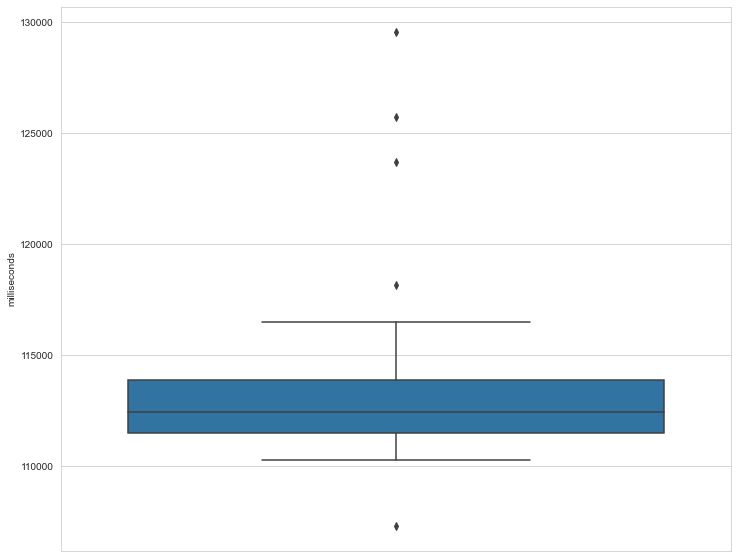

In [49]:
#Check out the distribution
sns.boxplot(y='milliseconds', data=df_max_belgian23)

>**Observation**: There are quite a few outliers in there. Let's graph it against the timeline.

<h3><a id="visualize-verstappen">Visualizing Lap Times for Max Verstappen @ 2023 Belgian Grand Prix</a></h3>

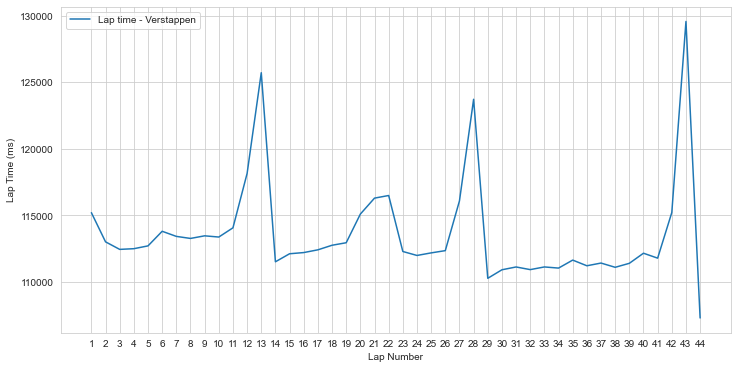

In [50]:
#Plot laps
fig = plt.figure(figsize=(12,6))
plt.plot(df_max_belgian23.index, df_max_belgian23.milliseconds, label='Lap time - Verstappen')
# plt.xlim(df_max_belgian23.lap.min(), df_max_belgian23.lap.max())
# ylim = plt.ylim(df_max_belgian23.milliseconds.min() - 100000, df_max_belgian23.milliseconds.max() + 100000)

ticks = plt.xticks(df_max_belgian23.index) 
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time (ms)') 
# title = plt.title('2023 Belgian Grand Prix Lap Times for Max Verstappen')
legend = plt.legend(loc='best')
plt.show()

In [204]:
df_max_belgian23

,milliseconds,stop_count,pit_stop_milliseconds,pitted
lap,,,,
1,115210,0.0000,0.0000,0
2,113020,0.0000,0.0000,0
3,112454,0.0000,0.0000,0
4,112506,0.0000,0.0000,0
5,112717,0.0000,0.0000,0
6,113813,0.0000,0.0000,0
7,113430,0.0000,0.0000,0
8,113276,0.0000,0.0000,0
9,113472,0.0000,0.0000,0


>**Observation**: There are 3 major spikes. Could the pit stops have caused them?

In [52]:
#do the spikes align with pit stops
df_max_belgian23[~df_max_belgian23.stop_count.isnull()]

,milliseconds,stop_count,pit_stop_milliseconds,pitted
lap,,,,
1,115210,0.0000,0.0000,0
2,113020,0.0000,0.0000,0
3,112454,0.0000,0.0000,0
4,112506,0.0000,0.0000,0
5,112717,0.0000,0.0000,0
6,113813,0.0000,0.0000,0
7,113430,0.0000,0.0000,0
8,113276,0.0000,0.0000,0
9,113472,0.0000,0.0000,0


Text(0.5, 0, 'Lap Number')

Text(0, 0.5, 'Lap & Pit Stop Time (ms)')

<BarContainer object of 44 artists>

(0.0, 120000.0)

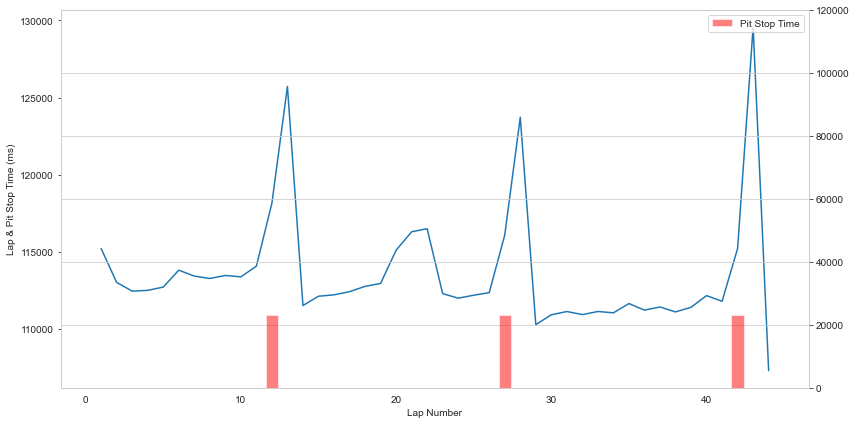

In [211]:
# Plot laps & pit stops
fig, ax1 = plt.subplots(figsize=(12, 6))

# Line plot for lap time
ax1.plot(df_max_belgian23.index, df_max_belgian23.milliseconds, label='Lap Time')
ax1.set_xlabel('Lap Number')
ax1.set_ylabel('Lap & Pit Stop Time (ms)')
ax1.tick_params(axis='y')

# Create bar graph for pit stop times
ax2 = ax1.twinx()
ax2.bar(df_max_belgian23.index, df_max_belgian23.pit_stop_milliseconds, label='Pit Stop Time', color='r', alpha=0.5)
# ax2.set_ylabel('Pit Stop Time (ms)')
ax2.set_ylim(0, 120000)  # Adjust the y-axis limit according to your data range
ax2.tick_params(axis='y')

ax1.grid(False)

fig.tight_layout()
# plt.title('2023 Belgian Grand Prix Lap Times for Max Verstappen')
legend = plt.legend(loc='best')
plt.show()


>**Observations**: Clearly, the pit stops account for the spikes. It's hard to tell what's going on trend-wise though, let's zoom out a bit

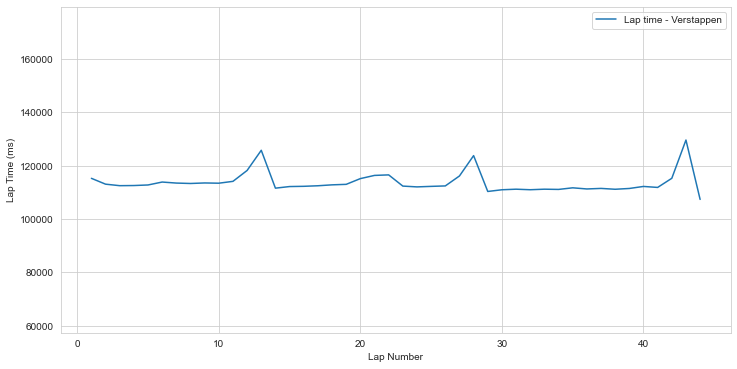

In [51]:
#plot with different scale
fig = plt.figure(figsize=(12,6))
# fig = plt.figure(figsize=(6,5))
plt.plot(df_max_belgian23.index, df_max_belgian23.milliseconds, label='Lap time - Verstappen')
# plt.xlim(df_max_belgian23.lap.min(), df_max_belgian23.lap.max())
ylim = plt.ylim(df_max_belgian23.milliseconds.min() - 50000, df_max_belgian23.milliseconds.max() + 50000)

# ticks = plt.xticks(df_max_belgian23.index) 
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time (ms)') 
# title = plt.title('2023 Belgian Grand Prix Lap Times for Max Verstappen')
legend = plt.legend(loc='best')
plt.show()

>**Observation**: Clearly there is no trend, only a change in level probably as the car goes faster after pit stops. Now, let's see how the lap times and peaks align with driver 844 especially after lap 19 which is suppose to be a rainfall period per the race reports. Also, why is lap one slow?

<h3><a id="driver-comparison">Max Verstappen vs Driver 844 @ 2023 Belgian Grand Prix</a></h3>

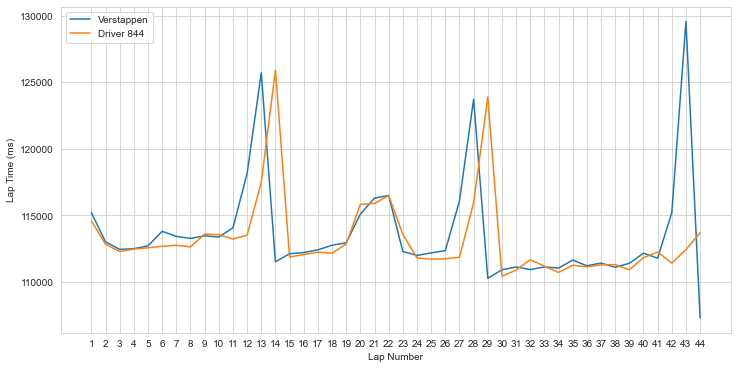

In [53]:
#Plot laps for both drivers
fig = plt.figure(figsize=(12,6))
# fig = plt.figure(figsize=(6,5))
plt.plot(df_max_belgian23.index, df_max_belgian23.milliseconds, label='Verstappen')
plt.plot(df_844_belgian23.index, df_844_belgian23.milliseconds, label='Driver 844')

# ticks = plt.xticks(df_max_belgian23.index) 
ticks = plt.xticks(df_max_belgian23.index) 
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time (ms)') 
# title = plt.title('2023 Belgian Grand Prix - Verstappen vs Driver 844')
legend = plt.legend(loc='best')
plt.show()

>**Conclusions**: 
- The longer lap time in lap 1 is explained by a brief yellow flag per the wikipedia page and the rain fall driven slow down afterbetween laps 18 to 21. Graphs for both drivers confirm this.
- The main difference between driver 844 and Verstappen is that Verstappen pits sooner and does so 3 times instead of 2.
- End to end, there is no trend really, only spikes due to pitting at laps 12, 27 and 42, which also explains the outliers in the box plot. The lack of trend must be due to drivers' consistent performance across laps. There's some noise of course as expected since not every lap will be completed at the exact same millisecond.
- The level chages every 10-15 laps right after a pit stop due to the car getting faster (which is expected). 
- There's naturally no seasonality since the spikes don't occur at fixed intervals but clearly there's irregular variance explained by the pit stops, rainfall and yellow flag. Let's check for stationarty afterwards.

<h3><a id="decomposition">Time Series Decomposition</a></h3>
Let's decompose the lap times series to see if we can visualize trend and seasonality, if any.

<Figure size 864x576 with 0 Axes>

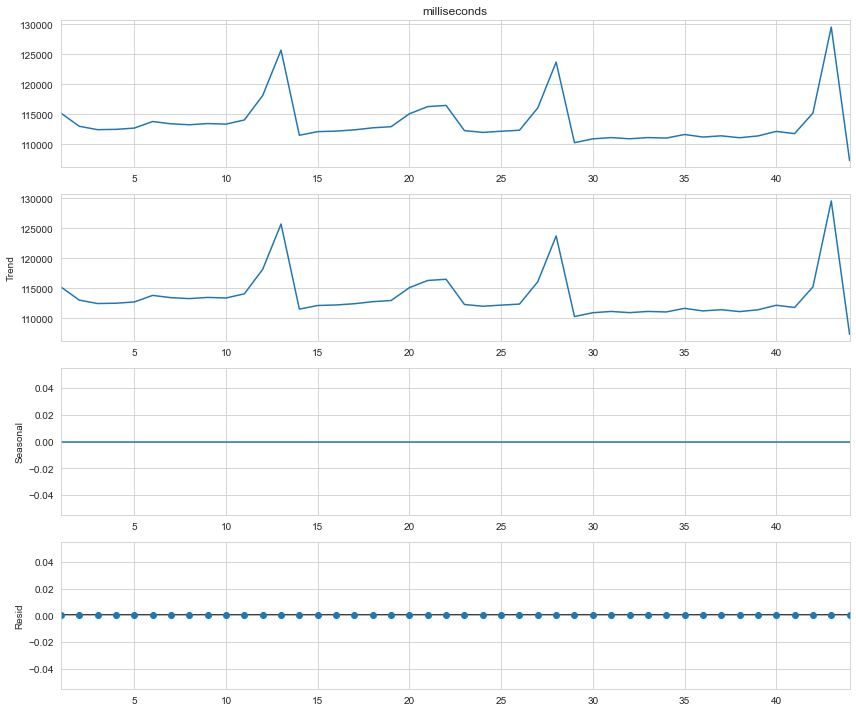

In [54]:
#additive decomposition
fig = plt.figure(figsize=(12,8))
decomposition = sm.tsa.seasonal_decompose(df_max_belgian23.milliseconds, model='additive', freq=1)
fig = decomposition.plot()
plt.show()

<Figure size 864x576 with 0 Axes>

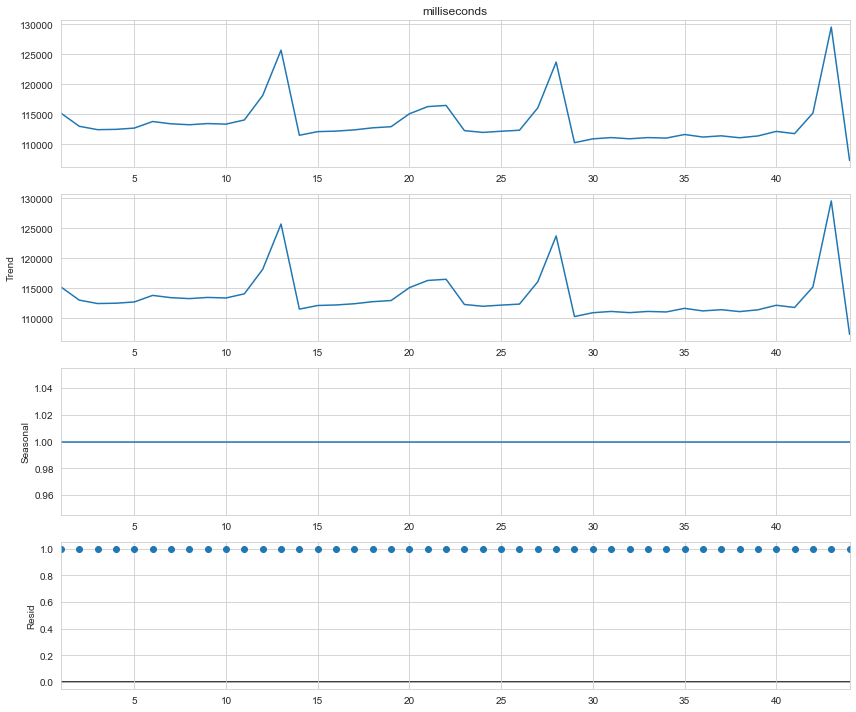

In [55]:
#multiplicative decomposition
fig = plt.figure(figsize=(12,8))
decomposition = sm.tsa.seasonal_decompose(df_max_belgian23.milliseconds, model='multiplicative',freq=1)
fig = decomposition.plot()
# fig.set_size_inches(6,5)
plt.show()

>**Observation**: There's no seasonality but for some reason the trend graph is not flat. The additive and multiplicatve decomposition algorithms do make some assumptions so let's try and verify stationarty through statistical tests.

>**Note**: I learnt later that significant auto-correlation (ACF & PACF) is present with lag 15. Visually too, there appears to it makes sense so let's see if we can use a seasonal period of 15 to do a better decomposition.

<Figure size 864x576 with 0 Axes>

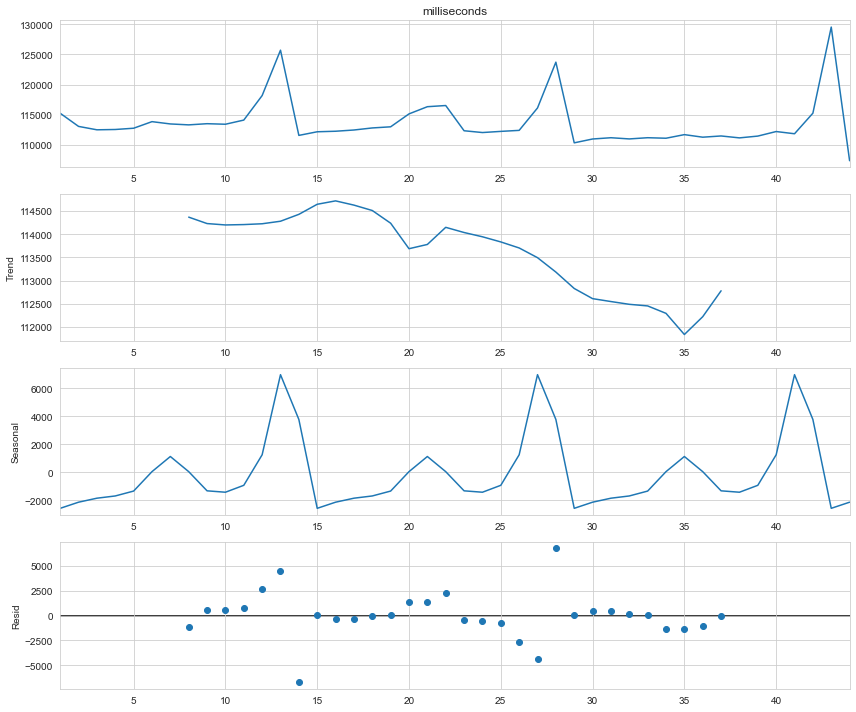

In [56]:
#additive decomposition
fig = plt.figure(figsize=(12,8))
decomposition = sm.tsa.seasonal_decompose(df_max_belgian23.milliseconds, model='additive', period=14)
fig = decomposition.plot()
plt.show()

<Figure size 864x576 with 0 Axes>

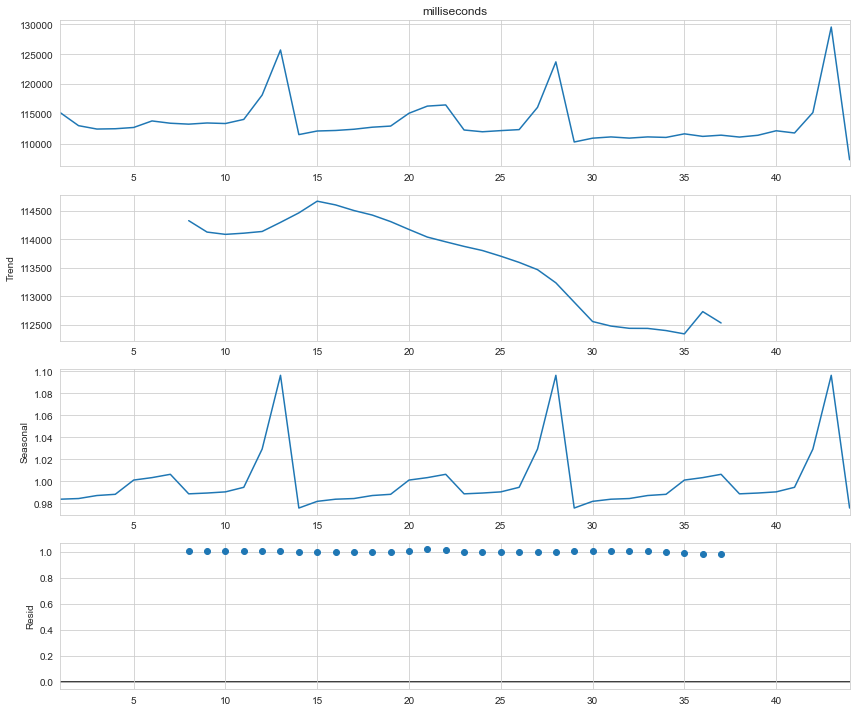

In [57]:
#multiplicative decomposition
fig = plt.figure(figsize=(12,8))
decomposition = sm.tsa.seasonal_decompose(df_max_belgian23.milliseconds, model='multiplicative', period=15)
fig = decomposition.plot()
plt.show()

>**Observations**: I am confused. The period=14 parameter with mulplicative decomposition demonstrates a seasonal pattern whereas a freuq=1 parameter with both additive and mulitpliciative decomposition indicate no seasonality. Let's do some statistical tests to verify!

<h3><a id="stationarity-tests">Stationarity Tests</a></h3>
Let's use statistical tests to determine whether the times series is stationary or not

In [58]:
#check stationarity with AD Fuller

adf_test = adfuller(df_max_belgian23.milliseconds)


print("ADF Statistic", adf_test[0]) #test statistic 
print("Critical value ", adf_test[4]['5%']) #critical value corresponding to 0.05 significance level
print("p-value ", adf_test[1])


ADF Statistic -5.915490875626008
Critical value  -2.931549768951162
p-value  2.5787754313809063e-07


In [59]:
#check stionarity one more time with KPSS

kpss_test = kpss(df_max_belgian23.milliseconds)

kpss_test
print("KPSS Statistic", kpss_test[0]) #test statistic
print("Critical value ", kpss_test[3]['5%']) #critical value corresponding to 0.05 significance level
print("p-value ", kpss_test[1])


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


(0.1396577383709503,
 0.1,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

KPSS Statistic 0.1396577383709503
Critical value  0.463
p-value  0.1


>**Observation**: The KPSS and ADFuller statistical tests both conclude that the time series is stationary which means that there is constant mean and variance. This makes sense given what we've observed visually in the series. As a last resort to verify stationarity though, let's run boxcox and differencing to see if it makes a difference and if it does not, then we'll be certain the time series is stationary.

<h3><a id="box-cox-transformation">Box Cox transformation</a></h3>
Box Cox will make to make the variance constant

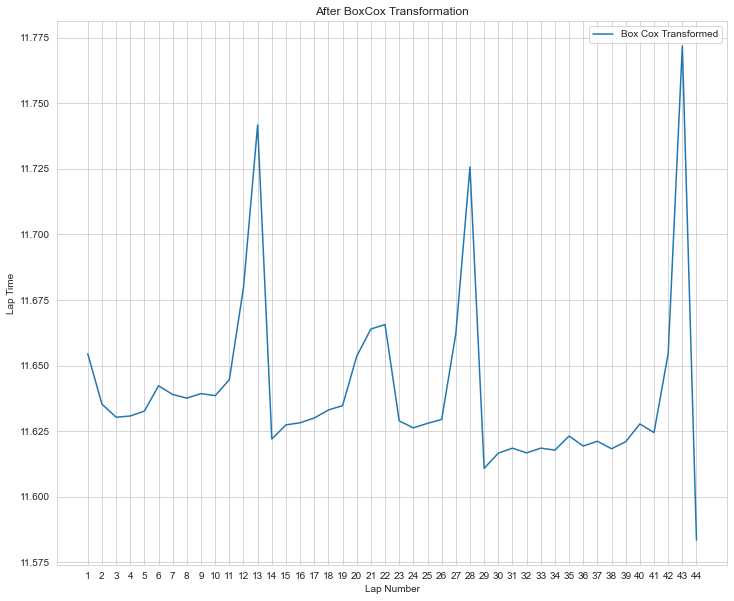

In [60]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(df_max_belgian23.milliseconds, lmbda=0), index = df_max_belgian23.index)

# plt.figure(figsize) = 12,4
plt.plot(data_boxcox, label = 'Box Cox Transformed')
# plt.plot(df_max_belgian23.milliseconds, label = 'Original Series')
ticks = plt.xticks(df_max_belgian23.index)
xlabel = plt.xlabel('Lap Number')
ylabel = plt.ylabel('Lap Time')
title = plt.title('After BoxCox Transformation')
legend = plt.legend(loc='best')

plt.show()

>**Observation**: The variance may have become a tad bit constant but I don't see any significant difference compared to the original series. 

<h3><a id="differencing">Differencing</a></h3>
This removes trend, let's see if it makes a difference

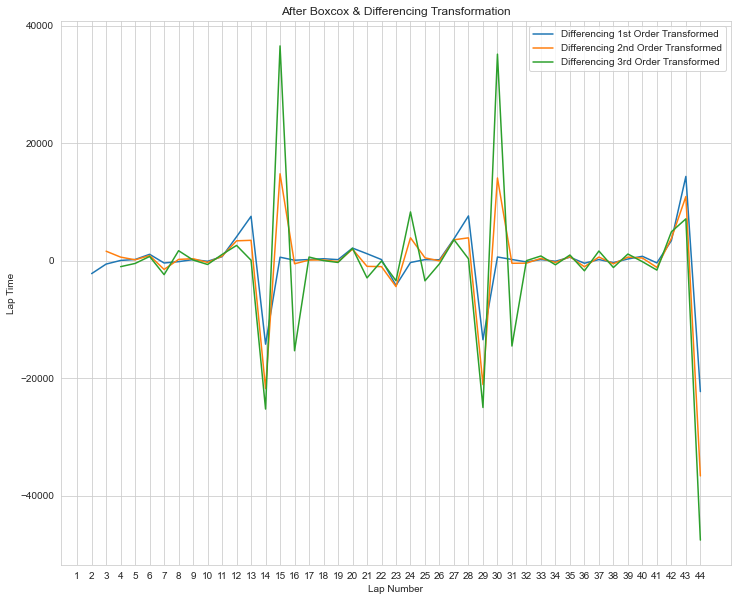

In [61]:
#remove trend from the original series with 2nd order differencing (tried with 1st order, didn't work)
data_diff = pd.Series(df_max_belgian23.milliseconds - df_max_belgian23.milliseconds.shift(), index = df_max_belgian23.index)
# data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index = data_boxcox.index)
data_diff.dropna(inplace=True)

data_diff2 = pd.Series(data_diff - data_diff.shift(), index = data_diff.index)
data_diff2.dropna(inplace=True)

data_diff3 = pd.Series(data_diff2 - data_diff2.shift(), index = data_diff2.index)
data_diff3.dropna(inplace=True)

plt.plot(data_diff, label = 'Differencing 1st Order Transformed')
plt.plot(data_diff2, label = 'Differencing 2nd Order Transformed')
plt.plot(data_diff3, label = 'Differencing 3rd Order Transformed')
# plt.plot(data_boxcox, label = 'Box Cox Transformed')
# plt.plot(df_max_belgian23.milliseconds, label = 'Original Series')


ticks = plt.xticks(df_max_belgian23.index)
xlabel = plt.xlabel('Lap Number')
ylabel = plt.ylabel('Lap Time')
title = plt.title('After Boxcox & Differencing Transformation')
legend = plt.legend(loc='best')

plt.show()

>**Conclusion**: Clearly, there's no trend and seasonality that needs to be removed. **The time series is indeed stationary**. This also means that we're free to use Auto Regression methods if we can establish auto-correlations so let's do that next.

In [62]:
# #plot for presentation
# #remove trend from the original series with 2nd order differencing (tried with 1st order, didn't work)
# data_diff = pd.Series(df_max_belgian23.milliseconds - df_max_belgian23.milliseconds.shift(), index = df_max_belgian23.index)
# # data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index = data_boxcox.index)
# data_diff.dropna(inplace=True)

# data_diff2 = pd.Series(data_diff - data_diff.shift(), index = data_diff.index)
# data_diff2.dropna(inplace=True)

# data_diff3 = pd.Series(data_diff2 - data_diff2.shift(), index = data_diff2.index)
# data_diff3.dropna(inplace=True)

# fig, ax = plt.subplots(figsize=(6, 5))
# plt.plot(data_diff, label = 'Transformed')
# plt.plot(df_max_belgian23.milliseconds, label = 'Original')
# # plt.plot(data_diff, label = 'Differencing 1st Order Transformed')
# # plt.plot(data_diff, label = 'Differencing 1st Order Transformed')
# # plt.plot(data_diff2, label = 'Differencing 2nd Order Transformed')
# # plt.plot(data_diff3, label = 'Differencing 3rd Order Transformed')
# # plt.plot(data_boxcox, label = 'Box Cox Transformed')
# # plt.plot(df_max_belgian23.milliseconds, label = 'Original Series')


# # ticks = plt.xticks(df_max_belgian23.index)
# xlabel = plt.xlabel('Lap Number')
# ylabel = plt.ylabel('Lap Time (ms)')
# # title = plt.title('After Boxcox & Differencing Transformation')
# legend = plt.legend(loc='best')

# plt.show()

<h3><a id="autocorrelation-analysis">AutoCorrelation Analysis</a></h3>
Let's analyze whether the lap times are auto-correlated

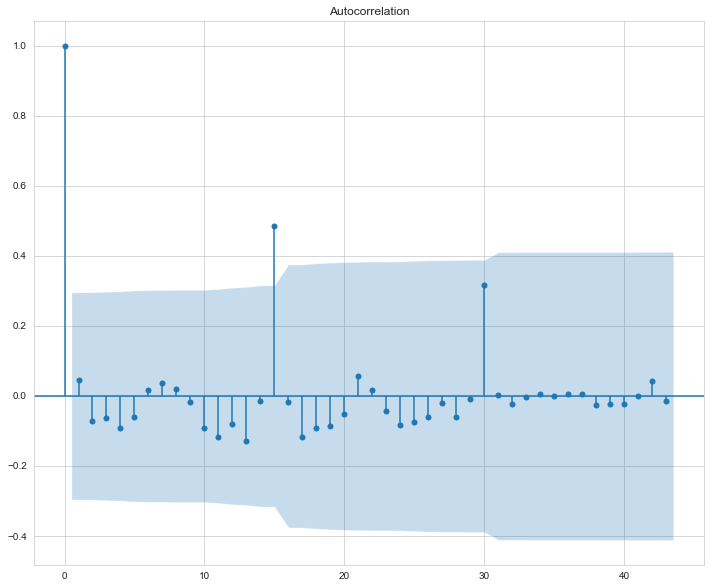

In [63]:
## Auto Correlation Factor
# fig, ax = plt.subplots(figsize=(6, 5))
# acf = plot_acf(df_max_belgian23.milliseconds, lags=43, ax=ax, title="")
acf = plot_acf(df_max_belgian23.milliseconds, lags=43)

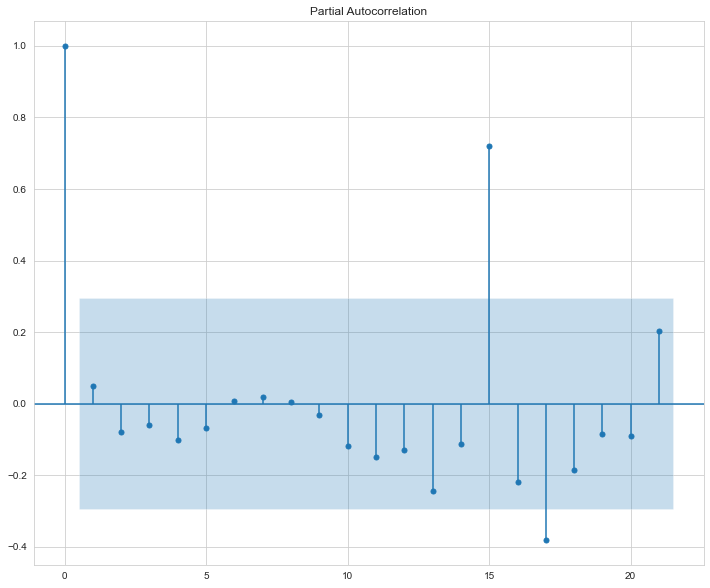

In [64]:
## Partial Auto Correlation Factor
# fig, ax = plt.subplots(figsize=(6, 5))
# pacf = plot_pacf(df_max_belgian23.milliseconds, lags=21, ax=ax, title="")
pacf = plot_pacf(df_max_belgian23.milliseconds, lags=21) #limited to 21 as PACF function can only go up to 50% of the sample size

>**Conclusion**: Both ACF and PACF indicate significant auto-correlation with lag 15 but with none of the other lags. Lag 30 comes close to significant in ACF and lag 21 gets clsoe to significance in PACF but there are no other instances. This is troubling because it may imply that we can forecast with AR models but only starting from the 16th lap onwards. Let's try building some models that include level, trend, seasonality and autocorrelation and both Exponential Smoothing and SARIMAX are good candidates. 

<h2><a id="modeling">Model Building & Evaulation</a></h2>

<h3><a id="train-test-split">Train-Test Split</a></h3>

In [65]:
#function to split data based on window width
def train_test_split(data, window_width):
    train= data[:window_width]
    test = data[window_width:window_width+5]
    return train, test


In [66]:
# train_size=35 
# data_train = df_max_belgian23[:train_size]
# data_test = df_max_belgian23[train_size:train_size+5] #For limiting forecast to 5 laps

## Train-test split (differenced)
# train_size=35 
# data_train = pd.DataFrame(data_diff[:train_size])
# data_test = pd.DataFrame(data_diff[train_size:train_size+5]) #For limiting forecast to 5 laps
# data_test

<h3><a id="error-measurement">Error Measurement</a></h3>
A datframe to record errors for each model

Let's use RMSE as the primary metric to evaluate models. Additionally, MAPE can give me  sense of the % of error. 

In [67]:
# results = pd.DataFrame(columns=['Model','Window_width','Model Parameters','RMSE','MAPE']) #df to capture results

results = pd.DataFrame()

# Check if the CSV file exists
file_name = 'Results.csv'
if os.path.exists(file_name):
    # Read the CSV file into a DataFrame
    results = pd.read_csv(file_name)
else:
    # If the file does not exist, create an empty DataFrame
    results = pd.DataFrame(columns=['Model','Window_width','Model Parameters','RMSE','MAPE'])

def store_results(model_name, window_width, params, rmse, mape):
    global results  # Declare results as global 
    results.loc[results.shape[0]] = [model_name, window_width, params, rmse, mape]
    results.to_csv('Results.csv', index=False) # Save the updated DataFrame to 'Results.csv'
    return results

In [68]:
results

,Model,Window_width,Model Parameters,RMSE,MAPE


<h3><a id="ses">Simple Exponential Smoothing</a></h3>
This captures level only so it's a reasonable place to start

<h3><a id="ses-baseline">SES - Baseline Model</a></h3>
Let's start with a low alpha and width of 35 laps which covers 2 pit stops

In [69]:
def build_model_ses(X,window_width, alpha):
    # prepare training dataset
#     train, test = X[0:window_width], X[window_width:window_width+5] #Limit train to 5 variables
    data_train, data_test = train_test_split(data=X, window_width=window_width)
    
    # train & forecast    
    model = SimpleExpSmoothing(data_train).fit(smoothing_level=alpha, optimized = False)
    print(model.summary())

    yhat = model.forecast(data_test.shape[0]+1).iloc[1:]

#     calculate out of sample error
    rmse = np.sqrt(mean_squared_error(data_test, yhat)).round(2)
    mape = np.round(np.mean(np.abs(data_test-yhat)/data_test),4)
    
    #store results
    store_results(model_name='SES', window_width=window_width, params= f"alpha={alpha}", rmse=rmse, mape=mape)
    
    return rmse, mape, yhat, data_train, data_test

rmse, mape, forecast,data_train, data_test = build_model_ses(df_max_belgian23.milliseconds, window_width=35, alpha=0.2)
results

                       SimpleExpSmoothing Model Results                       
Dep. Variable:           milliseconds   No. Observations:                   35
Model:             SimpleExpSmoothing   SSE                      413844008.034
Optimized:                      False   AIC                            573.998
Trend:                           None   BIC                            577.109
Seasonal:                        None   AICC                           575.331
Seasonal Periods:                None   Date:                 Tue, 28 May 2024
Box-Cox:                        False   Time:                         03:29:31
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2000000                alpha                False
initial_level             1.1521e+05                

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


,Model,Window_width,Model Parameters,RMSE,MAPE
0,SES,35,alpha=0.2,757.2600,0.0061


Text(0.5, 1.0, 'SIMPLE EXPONENTIAL SMOOTHING ')

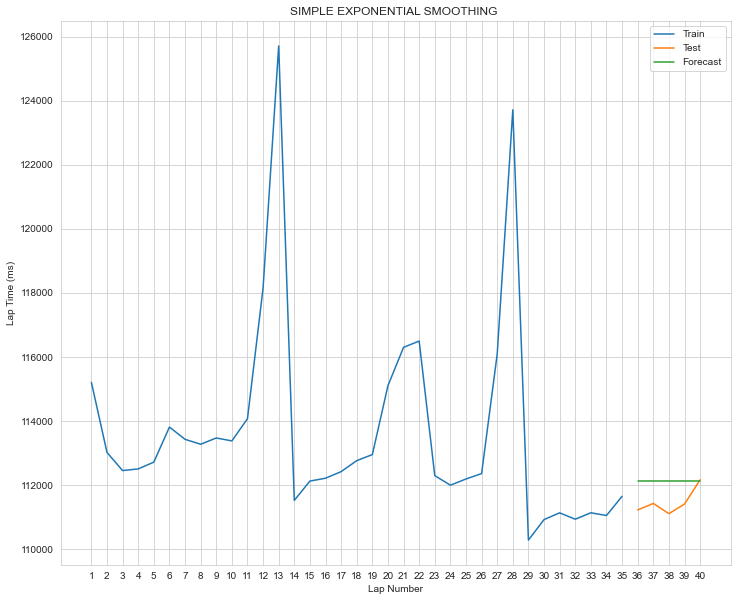

In [70]:
#plot train, test & forecast

plt.plot(data_train, label='Train')
plt.plot(data_test, label='Test')
plt.plot(forecast, label='Forecast')
plt.title('SIMPLE EXPONENTIAL SMOOTHING ')
ticks = plt.xticks(data_train.index.append(data_test.index)) 
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time (ms)') 
legend = plt.legend(loc='best')
plt.show()

>**Observations** 
For alpha = 0.2 , window width = 35, we get MAPE=0.0061  and RMSE=757.26. I might stick to this window width because 35 laps is 80% of the dataset which is fair and also because it captures 2 pit stops. The graph is pretty flat though compared to the test graph so it seems to capture the level only, let's try tuning the smoothing parameter. 

<h3><a id="ses-gs">SES - HyperParameter Tuning</a></h3>
Let's use grid search to tune alpha and window width

In [71]:
def build_model_ses(X,window_width, alpha):
    # prepare training dataset
    data_train, data_test = train_test_split(data=X, window_width=window_width)
    
    # train & forecast    
    model = SimpleExpSmoothing(data_train).fit(smoothing_level=alpha, optimized = False)
#     print(model.summary())
    yhat = model.forecast(data_test.shape[0]+1).iloc[1:]
    
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(data_test, yhat)).round(2)
    mape = np.round(np.mean(np.abs(data_test-yhat)/data_test),4)
    
    #store results
    store_results(model_name='SES-GS', window_width=window_width, params= f"alpha={alpha}", rmse=rmse, mape=mape)
    
    return rmse, mape, yhat, model

#Grid search. Best Params indicates alpha in the case of SES
def grid_search(dataset,window_widths, alpha_values):
    dataset = dataset.astype('float32')
    best_score, best_params, best_window_width, best_forecast = float("inf"), None, None, pd.Series() #captures best score & config
    
    for window_width in window_widths:
        for alpha in alpha_values:
            try:           
                rmse, mape, forecast, model = build_model_ses(dataset,window_width,alpha)
                if rmse < best_score:
                    best_score, best_params, best_window_width, best_forecast, best_model = rmse, alpha, window_width, forecast, model
            except Exception as e:
                continue
    
    print("Best Params ", best_params, " Best RMSE ", best_score, " Window-Width ", best_window_width)
    return best_score, best_params, best_window_width, best_forecast, best_model

# grid search parameters
alpha_values = [0.1, 0.2, 0.4, 0.6, 0.8]
window_widths = [12, 13,15,29,30,35]
best_score, best_params, best_window_width, best_forecast, best_model_ses =  grid_search(df_max_belgian23.milliseconds, window_widths, alpha_values)


<ipython-input-71-5a1e381a065c>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  best_score, best_params, best_window_width, best_forecast = float("inf"), None, None, pd.Series() #captures best score & config
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
 

Best Params  0.8  Best RMSE  259.82  Window-Width  30


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

In [72]:
best_model_ses.summary()

Dep. Variable:,milliseconds,No. Observations:,30
Model:,SimpleExpSmoothing,SSE,508180224.973
Optimized:,False,AIC,503.354
Trend:,None,BIC,506.157
Seasonal:,None,AICC,504.954
Seasonal Periods:,None,Date:,"Tue, 28 May 2024"
Box-Cox:,False,Time:,03:29:33
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8000000,alpha,False
initial_level,1.1521e+05,l.0,False


In [73]:
results[results.Model=='SES-GS'].sort_values('RMSE')

,Model,Window_width,Model Parameters,RMSE,MAPE
25,SES-GS,30,alpha=0.8,259.8200,0.0021
28,SES-GS,35,alpha=0.4,369.0200,0.0025
29,SES-GS,35,alpha=0.6,371.1400,0.0023
30,SES-GS,35,alpha=0.8,374.7200,0.0029
27,SES-GS,35,alpha=0.2,757.2600,0.0061
24,SES-GS,30,alpha=0.6,1081.0400,0.0095
14,SES-GS,15,alpha=0.6,1139.9300,0.0096
15,SES-GS,15,alpha=0.8,1192.7900,0.0064
26,SES-GS,35,alpha=0.1,1524.8400,0.0133
20,SES-GS,29,alpha=0.8,1602.3900,0.0144


In [74]:
results[results.Model=='SES-GS'].describe()

,RMSE,MAPE
count,30.0000,30.0000
mean,3396.2277,0.0284
std,2809.7648,0.0245
min,259.8200,0.0021
25%,1275.8025,0.0105
50%,2883.9900,0.0259
75%,5250.1800,0.0352
max,11832.4700,0.1054


Text(0.5, 1.0, 'Simple Exponential Smoothing ')

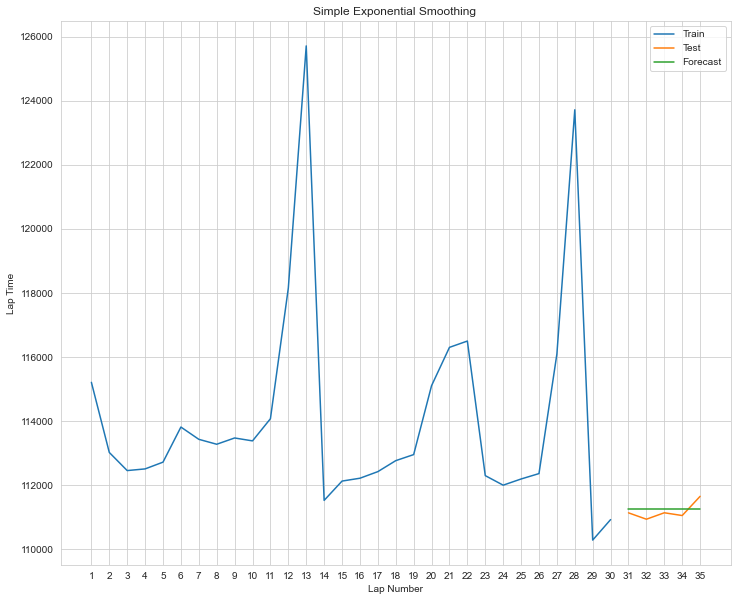

In [75]:
#plot the best model
data_train, data_test = train_test_split(data=df_max_belgian23.milliseconds, window_width=best_window_width)

plt.plot(data_train, label='Train')
plt.plot(data_test, label='Test')
plt.plot(best_forecast, label='Forecast')
plt.title('Simple Exponential Smoothing ')
# ticks = plt.xticks(df_max_belgian23.index) 
ticks = plt.xticks(data_train.index.append(data_test.index))
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time') 
legend = plt.legend(loc='best')
plt.show()

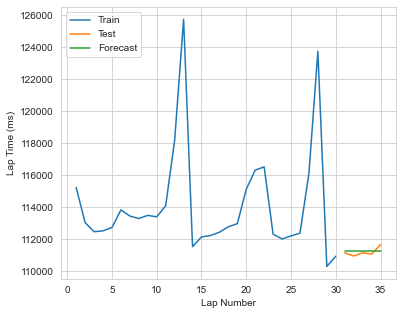

In [76]:
#plot for presentation
data_train, data_test = train_test_split(data=df_max_belgian23.milliseconds, window_width=best_window_width)
fig = plt.figure(figsize=(6,5))

plt.plot(data_train, label='Train')
plt.plot(data_test, label='Test')
plt.plot(best_forecast, label='Forecast')
# plt.title('SIMPLE EXPONENTIAL SMOOTHING (α=0.8)')
# ticks = plt.xticks(df_max_belgian23.index) 
# ticks = plt.xticks(data_train.index.append(data_test.index))

xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time (ms)') 
legend = plt.legend(loc='best')
plt.show()

>**Conclusions**: Best Alpha=0.8,  Best RMSE=259.82, MAPE=0.021,  Window-Width=30. The graph looks good too as it appears to capture the level, but that's too high an alpha and that means we're overindexing on the last observation. 

>I would prefer a model that can generalize reasonably well with lower alpha and lesser training data such as the one with Alpha 0.2, Window-Width 30, RMSE of 757.2600 & MAPE = 0.0061. 

>On the other hand, a high alpha may simply mean the the last few observations are significant in producing accurate forecasts in formula 1 as they reflect the most recent race conditions.

>Too early to determine which direction to go and in the absence of a well defined business objective, it's hard to say which model might be better. Let's add trend into the mix. 

<h3><a id="holt">Holt's Exponential Smoothing</a></h3>
This can handle level & trend so let's try it

<h3><a id="holt-baseline">Baseline Model</a></h3>
Let's start with window width 30 and let the internal optimization find the parameters

In [77]:
def build_model_holt(X,window_width, alpha, beta):
    # prepare training dataset
    data_train, data_test = train_test_split(data=X, window_width=window_width)
    
    # train & forecast    
    model = ExponentialSmoothing(data_train, trend='multiplicative', seasonal=None).fit(optimized=True)
    print(model.summary())

    yhat = model.forecast(data_test.shape[0]+1).iloc[1:]

#     calculate out of sample error
    rmse = np.sqrt(mean_squared_error(data_test, yhat)).round(2)
    mape = np.round(np.mean(np.abs(data_test-yhat)/data_test),4)
    
    #store results
    store_results(model_name='Holt', window_width=window_width, params= f"optimized=True", rmse=rmse, mape=mape)
    
    return rmse, mape, yhat, data_train, data_test

rmse, mape, forecast,data_train, data_test = build_model_holt(df_max_belgian23.milliseconds, window_width=30, alpha=0.2, beta=0.01)
results

                       ExponentialSmoothing Model Results                       
Dep. Variable:             milliseconds   No. Observations:                   30
Model:             ExponentialSmoothing   SSE                   133617994415.792
Optimized:                         True   AIC                            674.512
Trend:                   Multiplicative   BIC                            680.116
Seasonal:                          None   AICC                           678.164
Seasonal Periods:                  None   Date:                 Tue, 28 May 2024
Box-Cox:                          False   Time:                         03:29:33
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5235714                alpha                 True
smoothing_trend            0.13511

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


,Model,Window_width,Model Parameters,RMSE,MAPE
0,SES,35,alpha=0.2,757.2600,0.0061
1,SES-GS,12,alpha=0.1,5480.5300,0.0346
2,SES-GS,12,alpha=0.2,5472.2400,0.0354
3,SES-GS,12,alpha=0.4,5505.4900,0.0405
4,SES-GS,12,alpha=0.6,5699.4000,0.0458
5,SES-GS,12,alpha=0.8,6015.6600,0.0508
6,SES-GS,13,alpha=0.1,3348.8600,0.0296
7,SES-GS,13,alpha=0.2,4584.0000,0.0407
8,SES-GS,13,alpha=0.4,7362.5700,0.0655
9,SES-GS,13,alpha=0.6,9793.9800,0.0872


Text(0.5, 1.0, "Holt's Exponential Smoothing")

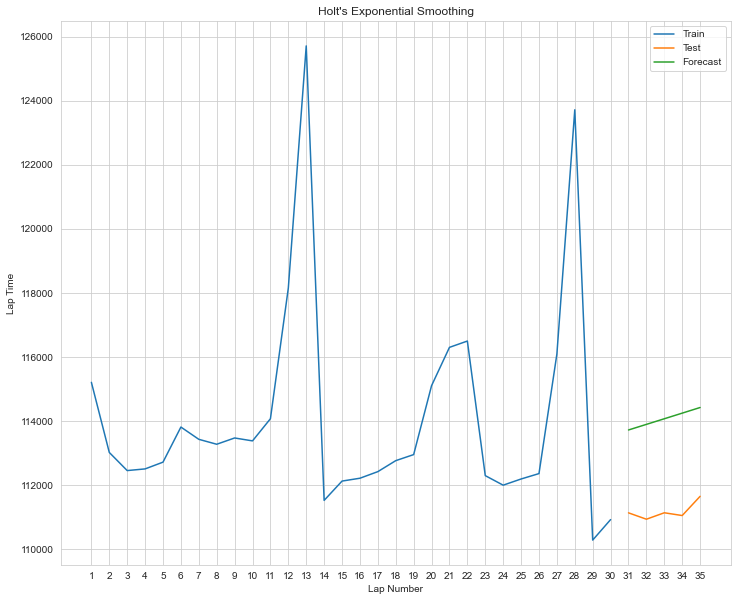

In [78]:
#plot train, test & forecast
plt.plot(data_train, label='Train')
plt.plot(data_test, label='Test')
plt.plot(forecast, label='Forecast')
plt.title('Holt\'s Exponential Smoothing')
ticks = plt.xticks(data_train.index.append(data_test.index)) 
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time') 
legend = plt.legend(loc='best')
plt.show()

>**Observation**: At RMSE=2898.5400 and MAPE=0.0260,  this is significantly worse than the SES models. But the upward trend has been forecasted quite well, so let's tune the hyperparameters to see if we can get the level right. 

<h3><a id="holt-gs">Holt's Exponential Smoothing - HyperParameter Tuning</a></h3>
Let's use grid search to tune alpha, beta and window width

In [79]:
def build_model_holt(X,window_width, alpha, beta):
    # prepare training dataset
    data_train, data_test = train_test_split(data=X, window_width=window_width)
    
    # train & forecast    

    model = ExponentialSmoothing(data_train, trend='multiplicative', seasonal=None).fit(smoothing_level=alpha, smoothing_slope=beta, optimized = False)
#     print(model.summary())
    yhat = model.forecast(data_test.shape[0]+1).iloc[1:]
    
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(data_test, yhat)).round(2)
    mape = np.round(np.mean(np.abs(data_test-yhat)/data_test),4)
    
    #store results
    store_results(model_name='Holt-GS', window_width=window_width, params= f"alpha={alpha} | beta={beta}", rmse=rmse, mape=mape)
    
    return rmse, mape, yhat, model

#Grid search
def grid_search(dataset,window_widths, alpha_values, beta_values):
    dataset = dataset.astype('float32')
    best_score, best_params, best_window_width, best_forecast = float("inf"), None, None, pd.Series(dtype='float64') #captures best score & config
    
    for window_width in window_widths:
        for alpha in alpha_values:
            for beta in beta_values:
                try:           
                    rmse, mape, forecast, model = build_model_holt(dataset,window_width,alpha, beta)
                    if rmse < best_score:
                        best_score, best_params, best_window_width, best_forecast, best_model = rmse, f"alpha={alpha} | beta={beta}", window_width, forecast, model
                except Exception as e:
                    continue
    
    print("Best Params ", best_params, " Best RMSE ", best_score, " Window-Width ", best_window_width)
    return best_score, best_params, best_window_width, best_forecast, best_model

# grid search parameters
# alpha_values = [0.1, 0.2, 0.4, 0.6, 0.8]
# beta_values = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.6,0.8]
# window_widths = [12, 13,15,29,30,35]

alpha_values = [0.2, 0.4, 0.5, 0.8]
beta_values = [0.01, 0.02, 0.04, 0.1]
window_widths = [30,35]
best_score, best_params, best_window_width, best_forecast, best_model_holt =  grid_search(df_max_belgian23.milliseconds, window_widths, alpha_values, beta_values)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

Best Params  alpha=0.2 | beta=0.1  Best RMSE  527.4  Window-Width  35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

In [80]:
best_model_holt.summary()

Dep. Variable:,milliseconds,No. Observations:,35
Model:,ExponentialSmoothing,SSE,994861233.845
Optimized:,False,AIC,608.697
Trend:,Multiplicative,BIC,614.918
Seasonal:,None,AICC,611.697
Seasonal Periods:,None,Date:,"Tue, 28 May 2024"
Box-Cox:,False,Time:,03:29:35
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2000000,alpha,False
smoothing_trend,0.1000000,beta,False


In [222]:
results[results.Model=='Holt-GS'].sort_values('RMSE').head(10)

,Model,Window_width,Model Parameters,RMSE,MAPE
51,Holt-GS,35,alpha=0.2 | beta=0.1,527.4000,0.0036
63,Holt-GS,35,alpha=0.8 | beta=0.1,887.9800,0.0061
43,Holt-GS,30,alpha=0.5 | beta=0.1,1004.6700,0.0080
59,Holt-GS,35,alpha=0.5 | beta=0.1,1397.3300,0.0111
55,Holt-GS,35,alpha=0.4 | beta=0.1,1440.0100,0.0115
47,Holt-GS,30,alpha=0.8 | beta=0.1,1451.3300,0.0116
39,Holt-GS,30,alpha=0.4 | beta=0.1,1662.1700,0.0145
38,Holt-GS,30,alpha=0.4 | beta=0.04,1867.9600,0.0136
42,Holt-GS,30,alpha=0.5 | beta=0.04,2047.4500,0.0154
62,Holt-GS,35,alpha=0.8 | beta=0.04,2591.2100,0.0211


In [223]:
results[results.Model=='Holt-GS'].describe()

,RMSE,MAPE
count,32.0000,32.0000
mean,4622.5672,0.0393
std,2920.8098,0.0258
min,527.4000,0.0036
25%,2002.5775,0.0152
50%,4512.3100,0.0383
75%,6716.8275,0.0567
max,11609.1500,0.1021


Text(0.5, 1.0, "Holt's Exponential Smoothing ")

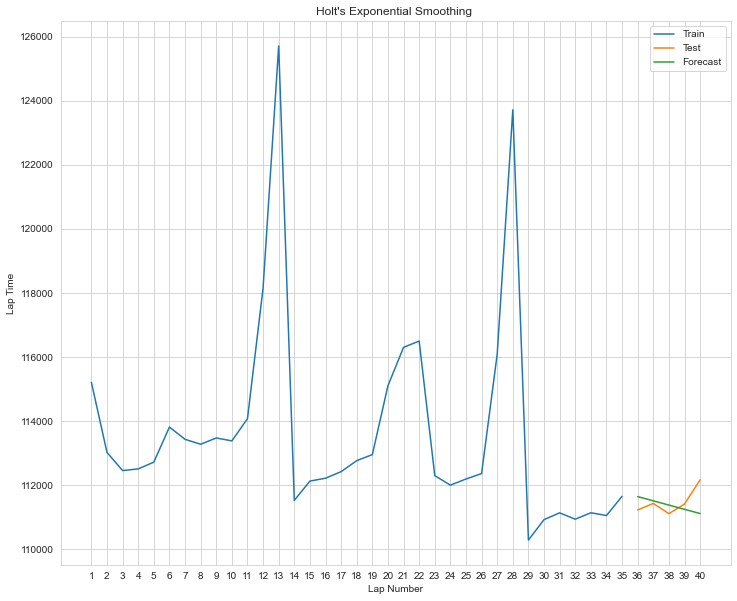

In [83]:
#plot the best model
data_train, data_test = train_test_split(data=df_max_belgian23.milliseconds, window_width=best_window_width)

plt.plot(data_train, label='Train')
plt.plot(data_test, label='Test')
plt.plot(best_forecast, label='Forecast')
plt.title('Holt\'s Exponential Smoothing ')
# ticks = plt.xticks(df_max_belgian23.index) 
ticks = plt.xticks(data_train.index.append(data_test.index))
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time') 
legend = plt.legend(loc='best')
plt.show()

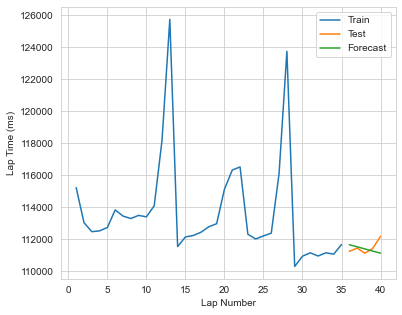

In [84]:
#plot for presentation
data_train, data_test = train_test_split(data=df_max_belgian23.milliseconds, window_width=best_window_width)
fig = plt.figure(figsize=(6,5))
plt.plot(data_train, label='Train')
plt.plot(data_test, label='Test')
plt.plot(best_forecast, label='Forecast')
# plt.title('Holt\'s Exponential Smoothing ')
# ticks = plt.xticks(df_max_belgian23.index) 
# ticks = plt.xticks(data_train.index.append(data_test.index))
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time (ms)') 
legend = plt.legend(loc='best')
plt.show()

>**Conclusions**: Best Holt's model with Window Width=35, alpha=0.2, beta=0.1 gives RMSE=527.4 & MAPE=0.0036. The graph looks like indicates that the trend's either headed in the wrong direction or lagging. At beta=0.1, we be too sensitive to trend. Although at 5 laps only, it's hard to tell what'll happen next until we test on a longer horizon. Maybe later. For now, let's add seasonality despite my misgivings about it. 

<h3><a id="holt-winters">Holt Winter's Exponential Smoothing</a></h3>
This can handle level, trend and seasonality. 

<h3><a id="holt-winters-baseline">Holt Winter's - Baseline Model</a></h3>
Let the internal optimization find the best params and go with window width of 35 since that worked once before during testing Holt Winters possibly because it provides sufficient data to learn seasonality. Also, let's take a seasonal period of 15 since that's about the time when the pit stops happen.

In [85]:
def build_model_holt_winters(X,window_width):
    # prepare training dataset
    data_train, data_test = train_test_split(data=X, window_width=window_width)
    
    # train & forecast    
    model = ExponentialSmoothing(data_train, seasonal_periods=15, trend='multiplicative', seasonal='mul').fit(optimized=True)
    print(model.summary())

    yhat = model.forecast(data_test.shape[0]+1).iloc[1:]

#     calculate out of sample error
    rmse = np.sqrt(mean_squared_error(data_test, yhat)).round(2)
    mape = np.round(np.mean(np.abs(data_test-yhat)/data_test),4)
    
    #store results
    store_results(model_name='Holt-Winters', window_width=window_width, params= f"optimized=true", rmse=rmse, mape=mape)
    
    return rmse, mape, yhat, data_train, data_test

rmse, mape, forecast,data_train, data_test = build_model_holt_winters(df_max_belgian23.milliseconds, window_width=35)

                       ExponentialSmoothing Model Results                       
Dep. Variable:             milliseconds   No. Observations:                   35
Model:             ExponentialSmoothing   SSE                       40796610.752
Optimized:                         True   AIC                            526.907
Trend:                   Multiplicative   BIC                            556.458
Seasonal:                Multiplicative   AICC                           597.984
Seasonal Periods:                    15   Date:                 Tue, 28 May 2024
Box-Cox:                          False   Time:                         03:29:36
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6060714                alpha                 True
smoothing_trend          

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [86]:
results[results.Model=='Holt-Winters'].sort_values('RMSE').head(10)

,Model,Window_width,Model Parameters,RMSE,MAPE
64,Holt-Winters,35,optimized=true,806.3500,0.0060


Text(0.5, 1.0, 'Holt Winters Exponential Smoothing')

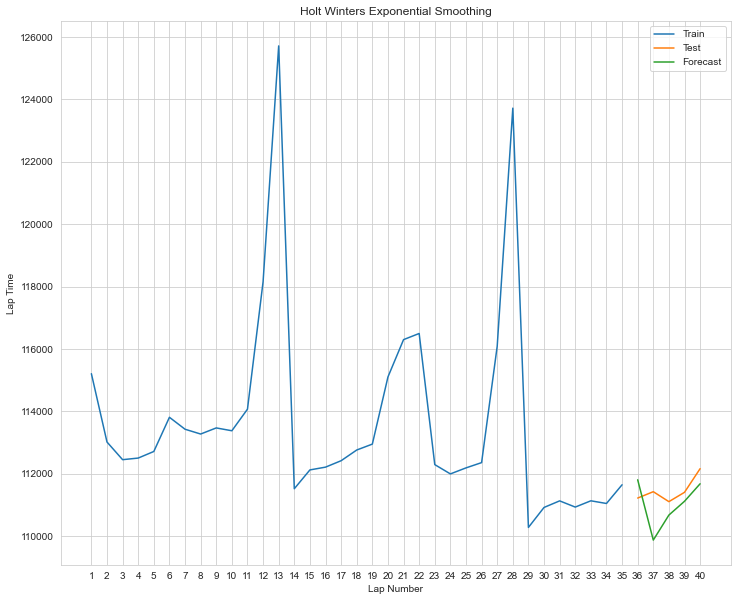

In [87]:
#plot train, test & forecast
plt.plot(data_train, label='Train')
plt.plot(data_test, label='Test')
plt.plot(forecast, label='Forecast')
plt.title('Holt Winters Exponential Smoothing')
ticks = plt.xticks(data_train.index.append(data_test.index)) 
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time') 
legend = plt.legend(loc='best')
plt.show()

>**Observation**: With optimized=true, Window Width = 30, RMSE=806.3500, MAPE=0.0060. That's quite good.
The forecast graph ties well to the test data as well. Can we make it better?

<h3><a id="holt-winters-gs">Holt Winter's - HyperParameter Tuning</a></h3>
Let's see if we can find better parameters through grid search

In [88]:
def build_model_holt_winters(X,window_width, alpha, beta, gamma, seasonal_period):
    # prepare training dataset
    data_train, data_test = train_test_split(data=X, window_width=window_width)
    # train & forecast    
    model = ExponentialSmoothing(data_train, seasonal_periods=seasonal_period, trend='add', seasonal='add').fit(smoothing_level=alpha, smoothing_slope=beta,smoothing_seasonal=gamma, optimized=False)

#     print(model.summary())
    yhat = model.forecast(data_test.shape[0]+1).iloc[1:]
    
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(data_test, yhat)).round(2)
    mape = np.round(np.mean(np.abs(data_test-yhat)/data_test),4)
    
    #store results
    store_results(model_name='Holt-Winters-GS', window_width=window_width, params= f"alpha={alpha} | beta={beta} | gamma={gamma} | seasonal_period={seasonal_period}", rmse=rmse, mape=mape)
    
    return rmse, mape, yhat, model

#Grid search
def grid_search(dataset,window_widths, alpha_values, beta_values, gamma_values, seasonal_periods):
    dataset = dataset.astype('float32')
    best_score, best_params, best_window_width, best_forecast = float("inf"), None, None, pd.Series(dtype='float64') #captures best score & config
    
    for window_width in window_widths:
        for alpha in alpha_values:
            for beta in beta_values:
                for gamma in gamma_values:
                    for seasonal_period in seasonal_periods:
                        try:           
                            rmse, mape, forecast, model = build_model_holt_winters(dataset,window_width,alpha, beta, gamma, seasonal_period)
                            if rmse < best_score:
                                best_score, best_params, best_window_width, best_forecast, best_model = rmse, f"alpha={alpha} | beta={beta} | gamma={gamma}| seasonal_period={seasonal_period}", window_width, forecast, model
                        except Exception as e:
                            continue
    
    print("Best Params ", best_params, " Best RMSE ", best_score, " Window-Width ", best_window_width)
    return best_score, best_params, best_window_width, best_forecast, best_model

# grid search parameters
alpha_values = [0.2, 0.4, 0.6, 0.8]
beta_values = [0.01, 0.02, 0.03, 0.04, 0.1]
gamma_values = [0.01, 0.02, 0.03, 0.04, 0.1]
window_widths = [30, 35]
seasonal_periods = [13, 15,17]
best_score, best_params, best_window_width, best_forecast, best_model_hw =  grid_search(df_max_belgian23.milliseconds, window_widths, alpha_values, beta_values, gamma_values, seasonal_periods)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

Best Params  alpha=0.2 | beta=0.04 | gamma=0.01| seasonal_period=15  Best RMSE  259.27  Window-Width  35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

In [89]:
best_model_hw.summary()

Dep. Variable:,milliseconds,No. Observations:,35
Model:,ExponentialSmoothing,SSE,58260456.859
Optimized:,False,AIC,539.378
Trend:,Additive,BIC,568.930
Seasonal:,Additive,AICC,610.455
Seasonal Periods:,15,Date:,"Tue, 28 May 2024"
Box-Cox:,False,Time:,03:29:43
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2000000,alpha,False
smoothing_trend,0.0400000,beta,False


In [90]:
#first 10 rows in results
results[results.Model=='Holt-Winters-GS'].sort_values('RMSE').head(10)

,Model,Window_width,Model Parameters,RMSE,MAPE
311,Holt-Winters-GS,35,alpha=0.2 | beta=0.04 | gamma=0.01 | seasonal_...,259.2700,0.0020
146,Holt-Winters-GS,30,alpha=0.4 | beta=0.04 | gamma=0.01 | seasonal_...,261.5000,0.0021
148,Holt-Winters-GS,30,alpha=0.4 | beta=0.04 | gamma=0.02 | seasonal_...,262.5600,0.0021
314,Holt-Winters-GS,35,alpha=0.2 | beta=0.04 | gamma=0.02 | seasonal_...,264.0000,0.0021
150,Holt-Winters-GS,30,alpha=0.4 | beta=0.04 | gamma=0.03 | seasonal_...,264.5600,0.0020
212,Holt-Winters-GS,30,alpha=0.6 | beta=0.1 | gamma=0.04 | seasonal_p...,264.5700,0.0022
407,Holt-Winters-GS,35,alpha=0.4 | beta=0.1 | gamma=0.03 | seasonal_p...,266.1600,0.0021
210,Holt-Winters-GS,30,alpha=0.6 | beta=0.1 | gamma=0.03 | seasonal_p...,266.9500,0.0022
152,Holt-Winters-GS,30,alpha=0.4 | beta=0.04 | gamma=0.04 | seasonal_...,267.4800,0.0020
214,Holt-Winters-GS,30,alpha=0.6 | beta=0.1 | gamma=0.1 | seasonal_pe...,267.5100,0.0019


In [91]:
results[results.Model=='Holt-Winters-GS'].describe()

,RMSE,MAPE
count,500.0000,500.0000
mean,1886.4997,0.0132
std,1959.6661,0.0116
min,259.2700,0.0018
25%,457.3475,0.0034
50%,1164.6600,0.0097
75%,1945.6175,0.0170
max,5928.8100,0.0368


Text(0.5, 1.0, "Holt Winter's Exponential Smoothing ")

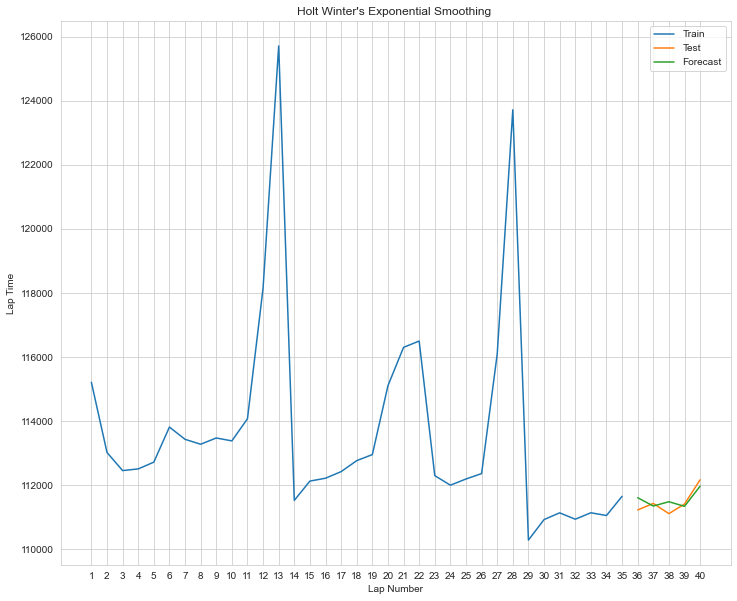

In [92]:
#plot the best model
data_train, data_test = train_test_split(data=df_max_belgian23.milliseconds, window_width=best_window_width)

plt.plot(data_train, label='Train')
plt.plot(data_test, label='Test')
plt.plot(best_forecast, label='Forecast')
plt.title('Holt Winter\'s Exponential Smoothing ')
# ticks = plt.xticks(df_max_belgian23.index) 
ticks = plt.xticks(data_train.index.append(data_test.index))
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time') 
legend = plt.legend(loc='best')
plt.show()

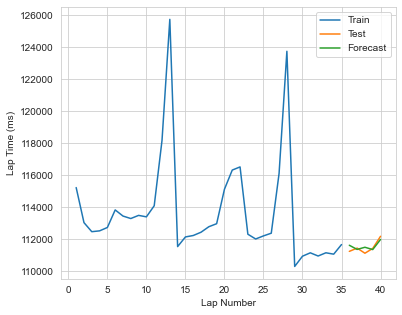

In [93]:
#plot for presentation
data_train, data_test = train_test_split(data=df_max_belgian23.milliseconds, window_width=best_window_width)
fig = plt.figure(figsize=(6,5))
plt.plot(data_train, label='Train')
plt.plot(data_test, label='Test')
plt.plot(best_forecast, label='Forecast')
# plt.title('Holt Winter\'s Exponential Smoothing ')
# ticks = plt.xticks(df_max_belgian23.index) 
# ticks = plt.xticks(data_train.index.append(data_test.index))
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time (ms)') 
legend = plt.legend(loc='best')
plt.show()

>**Conclusions**: Best Holt-Winter's model is Window Width=35, alpha=0.2, beta=0.04, gamma=0.01, seasonal periods=15 gives RMSE=259.27 & MAPE=0.002. By far, our best model RMSE-wise. 

> The low gamma indicates that we're placing less significance over seasonal characteristics of recent observations which means the model is learning from long-term seasonality which is good.

>The graph is quite good too but we don't have any real seasonal spikes in these 5 laps that would help us determine whether this is truly a good fit. Maybe build a walk-forward forecast later, if time permits.

>I have never held the opinion that the series has seasonality because the series is pretty flat and when a spike occurs, it's due to a planned pit stop which is not entirely a function of time. The race team determines for themselves the pit stop timings and normally plan these before the race which means we should treat the pit stop spikes as an exogenous variable which can be projected ahead of time. Having said that, it is also undeaniable that pit stops are some function of time in that pit stops do have a sort of rhythmic repetition but the time between pit stops isn't consistent which is also why I want to avoid treating this as seasonal. So let's go ahead and try including pit stops as an exogenous variable.

<h3><a id="arimax">ARIMAX</a></h3>
Inlcude pit stops as exogenous variable

<h3><a id="arimax-baseline">ARIMAX - Baseline Model</a></h3>
Since ACF and PACF both show autocorrelation with 15th lag (only), let's set p&q parameters to 15 & 15. Also, set d=1 to start with.

In [94]:
def build_model_arimax(X,window_width, p, d, q):
    # prepare training dataset
    data_train, data_test = train_test_split(data=X, window_width=window_width)
    
    # train & forecast
    model = SARIMAX(data_train.milliseconds, 
              order=(p,d,q), 
              seasonal_order=(0,0,0,0),
                exog=data_train['pitted']).fit()
    
    print(model.summary())
    
    # Ensure the exog data for prediction matches the forecast steps
    exog_test = data_test[['pitted']].iloc[:len(data_test)]

    #forecast on test
    yhat = model.predict(data_train.index.max(), (data_test.index.max()-1),exog=pd.DataFrame(data_test.pitted))
  
    rmse = np.sqrt(mean_squared_error(data_test.milliseconds, yhat)).round(2)
    mape = np.round(np.mean(np.abs(data_test.milliseconds-yhat)/data_test.milliseconds),4)
    
    #store results
    store_results(model_name='ARIMAX', window_width=window_width, params= f"p={p} | d={d} | q={q}", rmse=rmse, mape=mape)
    
    return rmse, mape, yhat, data_train, data_test

rmse, mape, forecast,data_train, data_test = build_model_arimax(df_max_belgian23, window_width=35, p=15, d=1, q=15)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                               SARIMAX Results                                
Dep. Variable:           milliseconds   No. Observations:                   35
Model:             SARIMAX(15, 1, 15)   Log Likelihood                -308.908
Date:                Tue, 28 May 2024   AIC                            681.815
Time:                        03:29:46   BIC                            730.659
Sample:                             0   HQIC                           698.473
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pitted     -1843.5000   8.27e+05     -0.002      0.998   -1.62e+06    1.62e+06
ar.L1         -0.0054     16.300     -0.000      1.000     -31.952      31.941
ar.L2          0.0022      8.504      0.000      1.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


>Event is the coefficient for exogneous variable (promo data), const is sigma2, ar.L1.y is coefficient of last observation (i.e. AR for 1st lag),  ma.L1.y is coefficient of last observation's forecast error (i.e. MA for 1st lag), ar.S.L12 is coefficient for 12th lag AR and ma.S.L12 is coefficient for 12th lag MA

In [95]:
#first 10 rows in results
results[results.Model=='ARIMAX'].sort_values('RMSE').head(10)

,Model,Window_width,Model Parameters,RMSE,MAPE
565,ARIMAX,35,p=15 | d=1 | q=15,1301.1900,0.0078


Text(0.5, 1.0, 'ARIMAX Model')

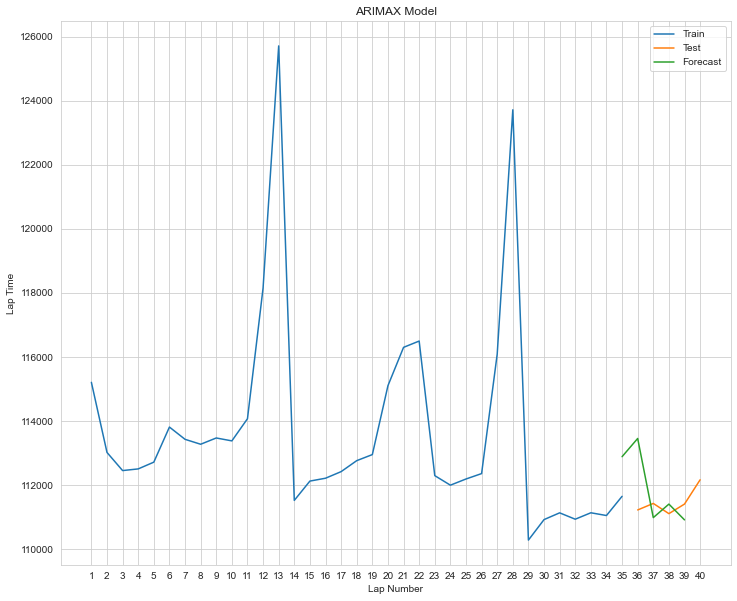

In [96]:
#plot the best model
plt.plot(data_train.milliseconds, label='Train')
plt.plot(data_test.milliseconds, label='Test')
plt.plot(forecast, label='Forecast')
plt.title('ARIMAX Model')
# ticks = plt.xticks(df_max_belgian23.index) 
ticks = plt.xticks(data_train.index.append(data_test.index))
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time') 
legend = plt.legend(loc='best')
plt.show()

>**Observation**: ARIMAX(15,1,15) has a MAPE of 0.0078 and RMSE of 1301.19 which is pretty decent. The big downside to ARIMAX is going to be the dependency on 15th lag. But let's try and optimize this model. 

<h3><a id="arimax-gs">ARIMAX - HyperParameter Tuning</a></h3>
Let's find the best p, d, q

In [97]:
def build_model_arimax(X,window_width, p, d, q):
    # prepare training dataset
    data_train, data_test = train_test_split(data=X, window_width=window_width)
    
    # train & forecast
    model = SARIMAX(data_train.milliseconds, 
              order=(p,d,q), 
              seasonal_order=(0,0,0,0),
                exog=data_train['pitted']).fit()
    
    
    # Ensure the exog data for prediction matches the forecast steps
    exog_test = data_test[['pitted']].iloc[:len(data_test)]

    #forecast on test
    yhat = model.predict(data_train.index.max(), (data_test.index.max()-1),exog=pd.DataFrame(data_test.pitted))
  
    rmse = np.sqrt(mean_squared_error(data_test.milliseconds, yhat)).round(2)
    mape = np.round(np.mean(np.abs(data_test.milliseconds-yhat)/data_test.milliseconds),4)
    
    #store results
    store_results(model_name='ARIMAX-GS', window_width=window_width, params= f"p={p} | d={d} | q={q}", rmse=rmse, mape=mape)
    
    return rmse, mape, yhat, model


#Grid search
def grid_search(dataset,window_widths, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_params, best_window_width, best_forecast = float("inf"), None, None, pd.Series(dtype='float64') #captures best score & config
    
    for window_width in window_widths:
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:           
                        rmse, mape, forecast, model = build_model_arimax(dataset,window_width,p,d,q)
                        if rmse < best_score:
                            best_score, best_params, best_window_width, best_forecast, best_model = rmse, f"p={p} | d={d} | q={q}", window_width, forecast, model
                    except Exception as e:
                        continue
    
    print("Best Params ", best_params, " Best RMSE ", best_score, " Window-Width ", best_window_width)
    return best_score, best_params, best_window_width, best_forecast, best_model

# grid search parameters
p_values = [1,2,3,4,15]
d_values = [0,1,2]
q_values = [1,2,3,4,5,15]
window_widths = [30, 35]

best_score, best_params, best_window_width, best_forecast, best_model_arimax =  grid_search(df_max_belgian23, window_widths, p_values, d_values, q_values)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Ana

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-p

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-p

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-p

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\stat

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodel

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\stat

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-package

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

Best Params  p=1 | d=1 | q=4  Best RMSE  244.22  Window-Width  30


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [98]:
best_model_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           milliseconds   No. Observations:                   30
Model:               SARIMAX(1, 1, 4)   Log Likelihood                -285.369
Date:                Tue, 28 May 2024   AIC                            584.738
Time:                        03:31:51   BIC                            594.309
Sample:                             0   HQIC                           587.736
                                 - 30                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pitted     -1843.5000   1087.552     -1.695      0.090   -3975.062     288.062
ar.L1         -0.0696     92.129     -0.001      0.999    -180.639     180.500
ma.L1          0.0401     92.133      0.000      1.000    -180.537     180.617
ma.L2         -0.0206      2.716     -0.008      0.994      -5.344       5.302
ma.L3         -0.0024      1.823     -0.001      0.999      -3.575       3.570
ma.L4         -0.0012      0.283     -0.004      0.997      -0.556       0.553
sigma2      1.174e+07      0.145   8.12e+07      0.000    1.17e+07    1.17e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.93   Jarque-Bera (JB):                41.38
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):              53.36   Skew:                            -1.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.04e+23. Standard errors may be unstable.
"""

In [99]:
#first 10 rows in results
results[results.Model=='ARIMAX-GS'].sort_values('RMSE')

,Model,Window_width,Model Parameters,RMSE,MAPE
575,ARIMAX-GS,30,p=1 | d=1 | q=4,244.2200,0.0008
593,ARIMAX-GS,30,p=2 | d=1 | q=4,244.2700,0.0008
609,ARIMAX-GS,30,p=3 | d=1 | q=2,245.0300,0.0007
591,ARIMAX-GS,30,p=2 | d=1 | q=2,246.2100,0.0007
574,ARIMAX-GS,30,p=1 | d=1 | q=3,247.0300,0.0009
590,ARIMAX-GS,30,p=2 | d=1 | q=1,247.7800,0.0008
608,ARIMAX-GS,30,p=3 | d=1 | q=1,248.0900,0.0008
573,ARIMAX-GS,30,p=1 | d=1 | q=2,249.1300,0.0007
626,ARIMAX-GS,30,p=4 | d=1 | q=1,249.2500,0.0008
627,ARIMAX-GS,30,p=4 | d=1 | q=2,250.7900,0.0007


In [100]:
results[results.Model=='ARIMAX-GS'].describe()

,RMSE,MAPE
count,180.0000,180.0000
mean,5721.3830,0.0503
std,12581.5071,0.1198
min,244.2200,0.0007
25%,1481.1975,0.0129
50%,3303.3900,0.0320
75%,6374.2725,0.0574
max,117068.0100,1.1108


Text(0.5, 1.0, 'ARIMAX')

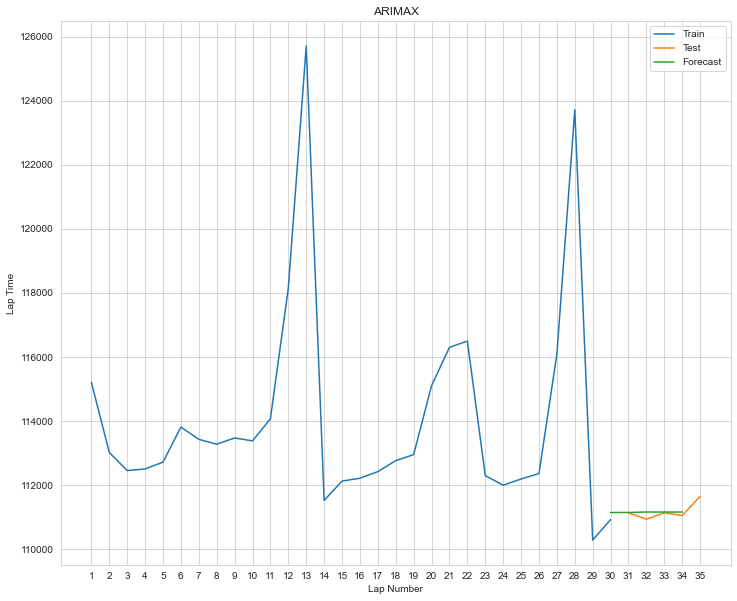

In [101]:
#plot the best model
data_train, data_test = train_test_split(data=df_max_belgian23, window_width=best_window_width)

plt.plot(data_train.milliseconds, label='Train')
plt.plot(data_test.milliseconds, label='Test')
plt.plot(best_forecast, label='Forecast')
plt.title('ARIMAX')
# ticks = plt.xticks(df_max_belgian23.index) 
ticks = plt.xticks(data_train.index.append(data_test.index))
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time') 
legend = plt.legend(loc='best')
plt.show()

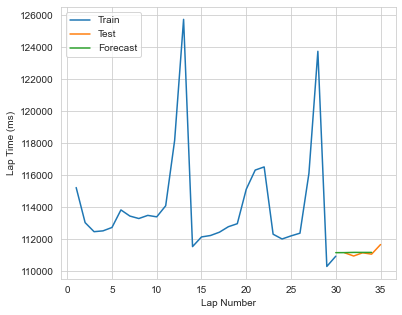

In [102]:
#plot for presentation
data_train, data_test = train_test_split(data=df_max_belgian23, window_width=best_window_width)
fig = plt.figure(figsize=(6,5))
plt.plot(data_train.milliseconds, label='Train')
plt.plot(data_test.milliseconds, label='Test')
plt.plot(best_forecast, label='Forecast')
# plt.title('ARIMAX')
# ticks = plt.xticks(df_max_belgian23.index) 
# ticks = plt.xticks(data_train.index.append(data_test.index))
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time (ms)') 
legend = plt.legend(loc='best')
plt.show()

>**Conclusions**: Best ARIMAX (1,1,4) model with Best RMSE  244.22  Window-Width  30  & MAPE=0.0007. That's our best model thus far! Exogenous variables might just be as valuable as I imagined. 

>Let's summary the models.

<h3><a id="model-comparison">Models Comparisons</a></h3>

In [103]:
#best models overall
results.sort_values('RMSE').head(10)

,Model,Window_width,Model Parameters,RMSE,MAPE
575,ARIMAX-GS,30,p=1 | d=1 | q=4,244.2200,0.0008
593,ARIMAX-GS,30,p=2 | d=1 | q=4,244.2700,0.0008
609,ARIMAX-GS,30,p=3 | d=1 | q=2,245.0300,0.0007
591,ARIMAX-GS,30,p=2 | d=1 | q=2,246.2100,0.0007
574,ARIMAX-GS,30,p=1 | d=1 | q=3,247.0300,0.0009
590,ARIMAX-GS,30,p=2 | d=1 | q=1,247.7800,0.0008
608,ARIMAX-GS,30,p=3 | d=1 | q=1,248.0900,0.0008
573,ARIMAX-GS,30,p=1 | d=1 | q=2,249.1300,0.0007
626,ARIMAX-GS,30,p=4 | d=1 | q=1,249.2500,0.0008
627,ARIMAX-GS,30,p=4 | d=1 | q=2,250.7900,0.0007


In [104]:
#best models for window size=30
results[results.Window_width==30].sort_values('RMSE').head(10)

,Model,Window_width,Model Parameters,RMSE,MAPE
575,ARIMAX-GS,30,p=1 | d=1 | q=4,244.2200,0.0008
593,ARIMAX-GS,30,p=2 | d=1 | q=4,244.2700,0.0008
609,ARIMAX-GS,30,p=3 | d=1 | q=2,245.0300,0.0007
591,ARIMAX-GS,30,p=2 | d=1 | q=2,246.2100,0.0007
574,ARIMAX-GS,30,p=1 | d=1 | q=3,247.0300,0.0009
590,ARIMAX-GS,30,p=2 | d=1 | q=1,247.7800,0.0008
608,ARIMAX-GS,30,p=3 | d=1 | q=1,248.0900,0.0008
573,ARIMAX-GS,30,p=1 | d=1 | q=2,249.1300,0.0007
626,ARIMAX-GS,30,p=4 | d=1 | q=1,249.2500,0.0008
627,ARIMAX-GS,30,p=4 | d=1 | q=2,250.7900,0.0007


In [105]:
#best models for window size=35
results[results.Window_width==35].sort_values('RMSE').head(10)

,Model,Window_width,Model Parameters,RMSE,MAPE
311,Holt-Winters-GS,35,alpha=0.2 | beta=0.04 | gamma=0.01 | seasonal_...,259.2700,0.0020
314,Holt-Winters-GS,35,alpha=0.2 | beta=0.04 | gamma=0.02 | seasonal_...,264.0000,0.0021
407,Holt-Winters-GS,35,alpha=0.4 | beta=0.1 | gamma=0.03 | seasonal_p...,266.1600,0.0021
410,Holt-Winters-GS,35,alpha=0.4 | beta=0.1 | gamma=0.04 | seasonal_p...,268.9100,0.0022
404,Holt-Winters-GS,35,alpha=0.4 | beta=0.1 | gamma=0.02 | seasonal_p...,269.0400,0.0020
317,Holt-Winters-GS,35,alpha=0.2 | beta=0.04 | gamma=0.03 | seasonal_...,270.9200,0.0022
401,Holt-Winters-GS,35,alpha=0.4 | beta=0.1 | gamma=0.01 | seasonal_p...,277.4000,0.0018
296,Holt-Winters-GS,35,alpha=0.2 | beta=0.03 | gamma=0.01 | seasonal_...,278.8400,0.0018
299,Holt-Winters-GS,35,alpha=0.2 | beta=0.03 | gamma=0.02 | seasonal_...,279.0000,0.0019
320,Holt-Winters-GS,35,alpha=0.2 | beta=0.04 | gamma=0.04 | seasonal_...,279.8700,0.0023


In [157]:
results[results.Model=='SES-GS'].sort_values('RMSE').head(1)

,Model,Window_width,Model Parameters,RMSE,MAPE
25,SES-GS,30,alpha=0.8,259.8200,0.0021


In [166]:
#df for best models
best_models = pd.DataFrame(columns=['Model', 'Window_width', 'Model Parameters', 'RMSE', 'MAPE'])

best_models = best_models.append(results[results.Model=='SES-GS'].sort_values('RMSE').head(1), ignore_index=True)
best_models = best_models.append(results[results.Model=='Holt-GS'].sort_values('RMSE').head(1), ignore_index=True)
best_models = best_models.append(results[results.Model=='Holt-Winters-GS'].sort_values('RMSE').head(1), ignore_index=True)
best_models = best_models.append(results[results.Model=='ARIMAX-GS'].sort_values('RMSE').head(1), ignore_index=True)

best_models['Model'] = best_models['Model'].str.replace('-GS', '')

In [167]:
best_models

,Model,Window_width,Model Parameters,RMSE,MAPE
0,SES,30,alpha=0.8,259.8200,0.0021
1,Holt,35,alpha=0.2 | beta=0.1,527.4000,0.0036
2,Holt-Winters,35,alpha=0.2 | beta=0.04 | gamma=0.01 | seasonal_...,259.2700,0.0020
3,ARIMAX,30,p=1 | d=1 | q=4,244.2200,0.0008


<Figure size 432x360 with 0 Axes>

<BarContainer object of 4 artists>

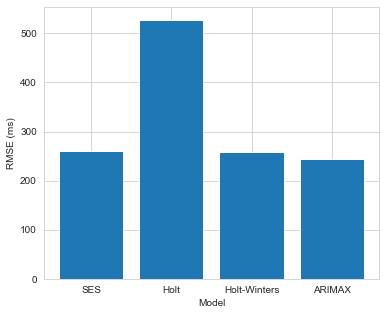

In [182]:
#Plotting Model Comparisons
plt.figure(figsize=(6, 5))

plt.bar(best_models['Model'], best_models['RMSE'])
# plt.bar(best_models['Model'], best_models['MAPE'], label='MAPE')

xlabel = plt.xlabel('Model')
ylabel = plt.ylabel('RMSE (ms)')
# title = plt.title('Model Comparison')
yticks = np.arange(0, max(results['RMSE']) + 100, 100)


# legend = plt.legend(loc='best')
plt.show()

>**Conclusion**: Clearly ARIMAX produces the lowest RMSE error. That may not mean it's the best model to put into production. One way to tell is to run a walk-forward forecast so say we train model on first 35 laps and forecast laps 36-40. Then we re-train the model on actual values of laps 1-40 and forecast for laps 41-45. We could effectively treat laps 41-45 as a holdout set and also see if we can get Verstappen's last forecast right. 

<h3><a id="walk-forward">Walk Forward Forecasts</a></h3>

<h3><a id="walk-forward-approach">Walk Forward Approach</a></h3>

1. Build a model by training on first 30 laps and use it to forecast laps 31-35

2. Retrain model with data from first 35 laps, forecast laps 36-40

3. Combine the two forecasts above and compare to actuals for error measurement for laps 31 to 40

<h3><a id="ses-walk-forward">SES - Walk Forward Forecast</a></h3>
Let's take our best model and use it to do a walk forward forecast.

In [217]:
def train_forecast(training_data, steps=6, alpha=0.8):
    #train
    model = SimpleExpSmoothing(training_data).fit(smoothing_level=alpha, optimized = False ) 

    #forecast
    forecast = pd.DataFrame()
    forecast = model.forecast(steps) #Forecast for next 5 laps
    return forecast

#Train-Test Split
train_size=35
data_train,data_test = df_max_belgian23[:train_size], df_max_belgian23[train_size:train_size+10] 


# y_hat = data_test.copy()
data_test['ses_best_walk_forward'] = None 
data_test.iloc[:5, data_test.columns.get_loc('ses_best_walk_forward')] = train_forecast(data_train.milliseconds)
data_test.iloc[5:, data_test.columns.get_loc('ses_best_walk_forward')] = train_forecast(training_data=pd.concat([data_train.milliseconds,data_test.milliseconds[:5]],axis=0))
# data_train
data_test


#Errors
rmse = np.sqrt(mean_squared_error(data_test.milliseconds, data_test.ses_best_walk_forward)).round(2)
mape = np.round(np.mean(np.abs(data_test.milliseconds-data_test.ses_best_walk_forward)/data_test.milliseconds),4)
rmse
mape


<ipython-input-217-cb2fc4f6c844>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['ses_best_walk_forward'] = None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy o

,milliseconds,stop_count,pit_stop_milliseconds,pitted,ses_best_walk_forward
lap,,,,,
36,111224,0.0000,0.0000,0,111532.1925
37,111428,0.0000,0.0000,0,111532.1925
38,111109,0.0000,0.0000,0,111532.1925
39,111408,0.0000,0.0000,0,111532.1925
40,112166,0.0000,0.0000,0,111532.1925
41,111796,0.0000,0.0000,0,112004.7642
42,115220,3.0000,23156.0000,1,112004.7642
43,129564,0.0000,0.0000,0,112004.7642
44,107305,0.0000,0.0000,0,112004.7642


6159.89

0.0248

Text(0.5, 1.0, 'Simple Exponential Smoothing - Walk Forward Forecast')

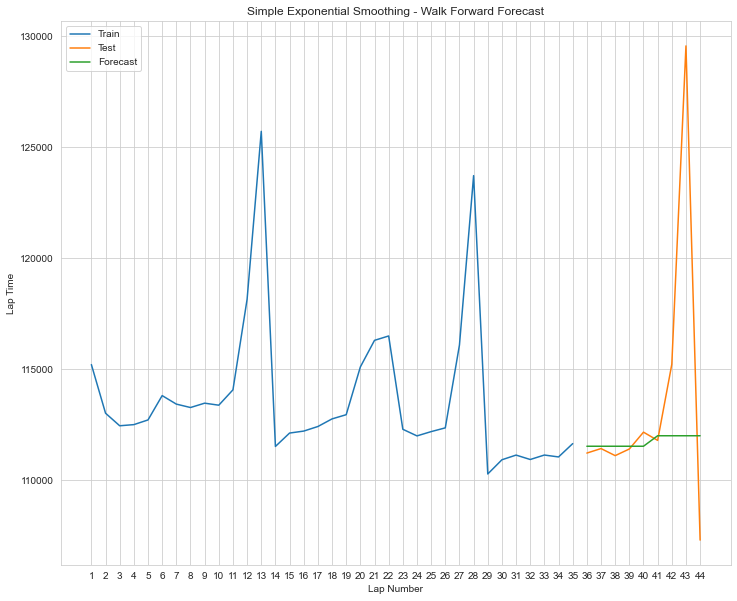

In [213]:
#plot the model
plt.plot(data_train.milliseconds, label='Train')
plt.plot(data_test.milliseconds, label='Test')
plt.plot(data_test.ses_best_walk_forward, label='Forecast')
plt.title('Simple Exponential Smoothing - Walk Forward Forecast')
# ticks = plt.xticks(df_max_belgian23.index) 
ticks = plt.xticks(data_train.index.append(data_test.index))
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time') 
legend = plt.legend(loc='best')
plt.show()

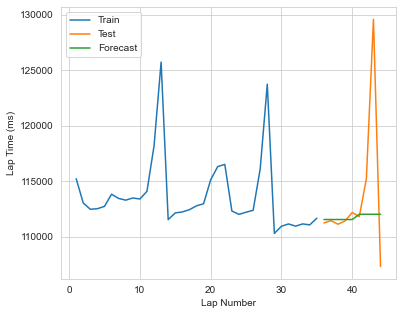

In [215]:
#plot the model for presentation
fig = plt.figure(figsize=(6,5))
plt.plot(data_train.milliseconds, label='Train')
plt.plot(data_test.milliseconds, label='Test')
plt.plot(data_test.ses_best_walk_forward, label='Forecast')
# plt.title('Simple Exponential Smoothing - Walk Forward Forecast')
# ticks = plt.xticks(df_max_belgian23.index) 
# ticks = plt.xticks(data_train.index.append(data_test.index))
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time (ms)') 
legend = plt.legend(loc='best')
plt.show()

RMSE=6159.89, MAPE=0.0248

<h3><a id="holt-winter's-walk-forward">Holt Winters - Walk Forward Forecast</a></h3>
Let's take our best Holt Winters model and use it to do a walk forward forecast.

In [109]:
def train_forecast(training_data, steps=6, alpha=0.2, gamma=0.01, beta=0.04 , seasonal_periods=15):
    #train
    model = ExponentialSmoothing(training_data, seasonal_periods=seasonal_periods, trend='add', seasonal='add').fit(smoothing_level=alpha, smoothing_slope=beta,smoothing_seasonal=gamma, optimized=False)

    #forecast
    forecast = pd.DataFrame()
    forecast = model.forecast(steps) #Forecast for next 5 laps
    return forecast

#Train-Test Split
train_size=35
data_train,data_test = df_max_belgian23[:train_size], df_max_belgian23[train_size:train_size+10] 


# y_hat = data_test.copy()
data_test['hw_best_walk_forward'] = None 
data_test.iloc[:5, data_test.columns.get_loc('hw_best_walk_forward')] = train_forecast(data_train.milliseconds)
data_test.iloc[5:, data_test.columns.get_loc('hw_best_walk_forward')] = train_forecast(training_data=pd.concat([data_train.milliseconds,data_test.milliseconds[:5]],axis=0))
# data_train
data_test


#Errors
rmse = np.sqrt(mean_squared_error(data_test.milliseconds, data_test.hw_best_walk_forward)).round(2)
mape = np.round(np.mean(np.abs(data_test.milliseconds-data_test.hw_best_walk_forward)/data_test.milliseconds),4)
rmse
mape


<ipython-input-109-a6c25a5bc67c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['hw_best_walk_forward'] = None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,milliseconds,stop_count,pit_stop_milliseconds,pitted,hw_best_walk_forward
lap,,,,,
36,111224,0.0000,0.0000,0,111606.3774
37,111428,0.0000,0.0000,0,111346.4454
38,111109,0.0000,0.0000,0,111481.3574
39,111408,0.0000,0.0000,0,111337.3810
40,112166,0.0000,0.0000,0,111966.9855
41,111796,0.0000,0.0000,0,116015.9796
42,115220,3.0000,23156.0000,1,123522.0998
43,129564,0.0000,0.0000,0,109281.2813
44,107305,0.0000,0.0000,0,109827.1877


7489.39

0.0333

Text(0.5, 1.0, "Holt Winter's Exponential Smoothing - Walk Forward Forecast")

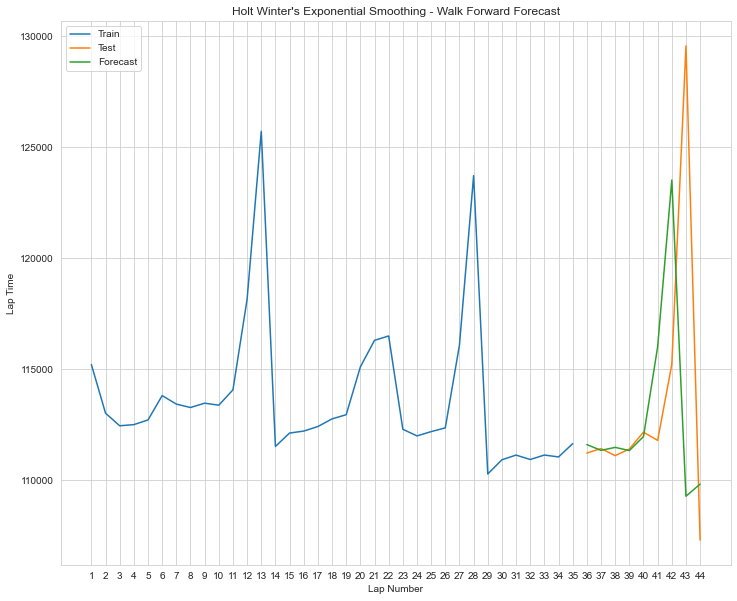

In [110]:
#plot the best model
plt.plot(data_train.milliseconds, label='Train')
plt.plot(data_test.milliseconds, label='Test')
plt.plot(data_test.hw_best_walk_forward, label='Forecast')
plt.title('Holt Winter\'s Exponential Smoothing - Walk Forward Forecast')
# ticks = plt.xticks(df_max_belgian23.index) 
ticks = plt.xticks(data_train.index.append(data_test.index))
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time') 
legend = plt.legend(loc='best')
plt.show()

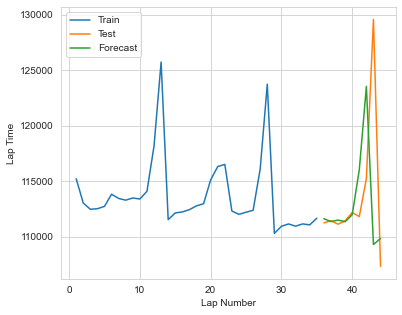

In [111]:
#plot for presentation
fig = plt.figure(figsize=(6,5))
plt.plot(data_train.milliseconds, label='Train')
plt.plot(data_test.milliseconds, label='Test')
plt.plot(data_test.hw_best_walk_forward, label='Forecast')
# plt.title('Holt Winter\'s Exponential Smoothing - Walk Forward Forecast')
# ticks = plt.xticks(df_max_belgian23.index) 
# ticks = plt.xticks(data_train.index.append(data_test.index))
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time') 
legend = plt.legend(loc='best')
plt.show()

RMSE=7489.39, MAPE=0.0333

<h3><a id="arimax-walk-forward">ARIMAX - Walk Forward Forecast</a></h3>
Let's take our best Holt Winters model and use it to do a walk forward forecast.

In [219]:
#Train-Test Split
train_size=35
p=1
d=1
q=4

forecast1 = pd.DataFrame()


#model fist 5 laps
data_train,data_test = df_max_belgian23[:train_size], df_max_belgian23[train_size:] 
data_test['arimax_best_walk_forward'] = None

model = SARIMAX(data_train.milliseconds, order=(p,d,q), seasonal_order=(0,0,0,0), exog=data_train['pitted']).fit()
forecast1 = model.predict(data_train.index.max(), (data_test.index.min()+3),exog=pd.DataFrame(data_test.pitted).head(5))
data_test.iloc[:5, data_test.columns.get_loc('arimax_best_walk_forward')] = forecast1


#model first 5 laps
updated_data_train = pd.concat([data_train, data_test[:6]], axis=0).reset_index(drop=True)
updated_data_test = data_test[5:]

model2 = SARIMAX(updated_data_train.milliseconds, order=(p,d,q), seasonal_order=(0,0,0,0), exog=updated_data_train['pitted']).fit()
forecast2 = model2.predict(updated_data_train.index.max(), (updated_data_test.index.min()+3),exog=pd.DataFrame(updated_data_test.pitted).head(6))
data_test.iloc[4:, data_test.columns.get_loc('arimax_best_walk_forward')] = forecast2


#Errors
rmse = np.sqrt(mean_squared_error(data_test.milliseconds, data_test.arimax_best_walk_forward)).round(2)
mape = np.round(np.mean(np.abs(data_test.milliseconds-data_test.arimax_best_walk_forward)/data_test.milliseconds),4)
rmse
mape


<ipython-input-219-888bf1f2953e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['arimax_best_walk_forward'] = None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zero

6360.25

0.0263

Text(0.5, 1.0, 'ARIMAX Exponential Smoothing - Walk Forward Forecast')

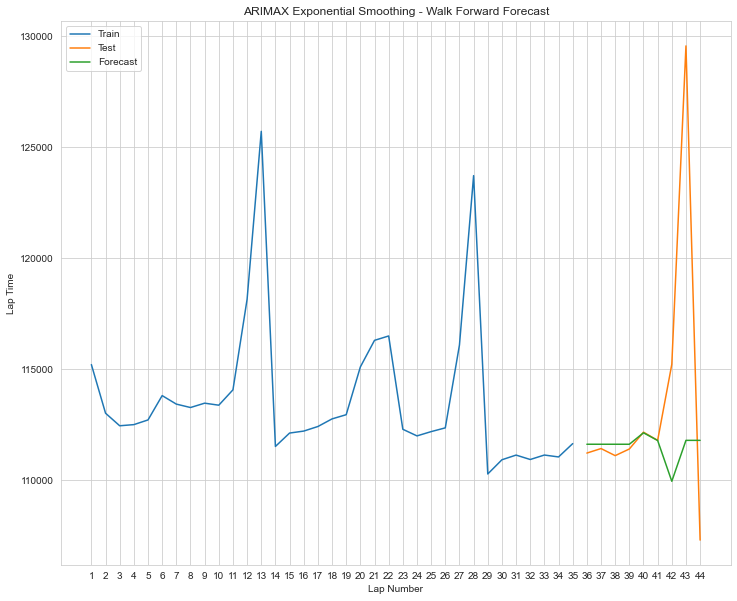

In [220]:
#plot the best model
plt.plot(data_train.milliseconds, label='Train')
plt.plot(data_test.milliseconds, label='Test')
plt.plot(data_test.arimax_best_walk_forward, label='Forecast')
plt.title('ARIMAX Exponential Smoothing - Walk Forward Forecast')
# ticks = plt.xticks(df_max_belgian23.index) 
ticks = plt.xticks(data_train.index.append(data_test.index))
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time') 
legend = plt.legend(loc='best')
plt.show()

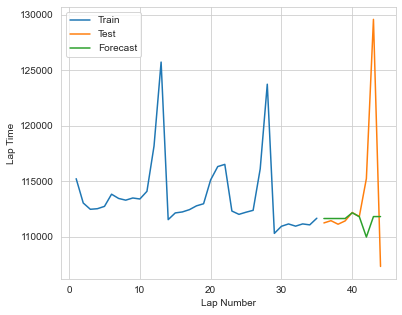

In [221]:
#plot for presentation
fig = plt.figure(figsize=(6,5))
plt.plot(data_train.milliseconds, label='Train')
plt.plot(data_test.milliseconds, label='Test')
plt.plot(data_test.arimax_best_walk_forward, label='Forecast')
# plt.title('ARIMAX Exponential Smoothing - Walk Forward Forecast')
# ticks = plt.xticks(df_max_belgian23.index) 
# ticks = plt.xticks(data_train.index.append(data_test.index))
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time') 
legend = plt.legend(loc='best')
plt.show()

RMSE=6320.89, MAPE=0.0309

**Conclusion**: SES walk forward is the best but hardly so. All walk forward forecassts are pretty horrible compared to their performance in the 5-lap forecast. When I reduce the window width for SES to 30 then the performance improved and that's because the pit stop time is not included until after lap 40. Clearly, we can not predict pit stops accurately just yet. Some improvements are needed but let's park them for now.  

<h2><a id="driver844">Forecasting Driver 844's Lap Times</a></h2>

<h3><a id="ses-gs-844">SES - Grid Search</a></h3>
Let's use grid search to tune alpha and window width

In [115]:
def build_model_ses(X,window_width, alpha):
    # prepare training dataset
    data_train, data_test = train_test_split(data=X, window_width=window_width)
    
    # train & forecast    
    model = SimpleExpSmoothing(data_train).fit(smoothing_level=alpha, optimized = False)
#     print(model.summary())
    yhat = model.forecast(data_test.shape[0]+1).iloc[1:]
    
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(data_test, yhat)).round(2)
    mape = np.round(np.mean(np.abs(data_test-yhat)/data_test),4)
    
    #store results
    store_results(model_name='SES-GS-844', window_width=window_width, params= f"alpha={alpha}", rmse=rmse, mape=mape)
    
    return rmse, mape, yhat

#Grid search. Best Params indicates alpha in the case of SES
def grid_search(dataset,window_widths, alpha_values):
    dataset = dataset.astype('float32')
    best_score, best_params, best_window_width, best_forecast = float("inf"), None, None, pd.Series() #captures best score & config
    
    for window_width in window_widths:
        for alpha in alpha_values:
            try:           
                rmse, mape, forecast = build_model_ses(dataset,window_width,alpha)
                if rmse < best_score:
                    best_score, best_params, best_window_width, best_forecast = rmse, alpha, window_width, forecast
            except Exception as e:
                continue
    
    print("Best Params ", best_params, " Best RMSE ", best_score, " Window-Width ", best_window_width)
    return best_score, best_params, best_window_width, best_forecast

# grid search parameters
alpha_values = [0.1, 0.2, 0.4, 0.6, 0.8]
window_widths = [12, 13,15,29,30,35]
best_score, best_params, best_window_width, best_forecast =  grid_search(df_844_belgian23.milliseconds, window_widths, alpha_values)


<ipython-input-115-507d80918d3e>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  best_score, best_params, best_window_width, best_forecast = float("inf"), None, None, pd.Series() #captures best score & config
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.


Best Params  0.4  Best RMSE  324.08  Window-Width  35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramDa

In [116]:
results[results.Model=='SES-GS-844'].sort_values('RMSE')

,Model,Window_width,Model Parameters,RMSE,MAPE
773,SES-GS-844,35,alpha=0.4,324.0800,0.0026
775,SES-GS-844,35,alpha=0.8,324.5000,0.0022
774,SES-GS-844,35,alpha=0.6,328.2300,0.0022
772,SES-GS-844,35,alpha=0.2,1014.0200,0.0087
770,SES-GS-844,30,alpha=0.8,1654.6600,0.0146
771,SES-GS-844,35,alpha=0.1,1763.8500,0.0156
760,SES-GS-844,15,alpha=0.8,1917.8900,0.0167
756,SES-GS-844,15,alpha=0.1,2268.5900,0.0193
757,SES-GS-844,15,alpha=0.2,2903.4600,0.0235
769,SES-GS-844,30,alpha=0.6,3149.4400,0.0282


In [117]:
results[results.Model=='SES-GS-844'].describe()

,RMSE,MAPE
count,30.0000,30.0000
mean,4209.8597,0.0322
std,2543.3234,0.0210
min,324.0800,0.0022
25%,2427.3075,0.0204
50%,3758.9500,0.0326
75%,5895.8350,0.0342
max,11152.1700,0.1004


Text(0.5, 1.0, 'Simple Exponential Smoothing - Driver 844')

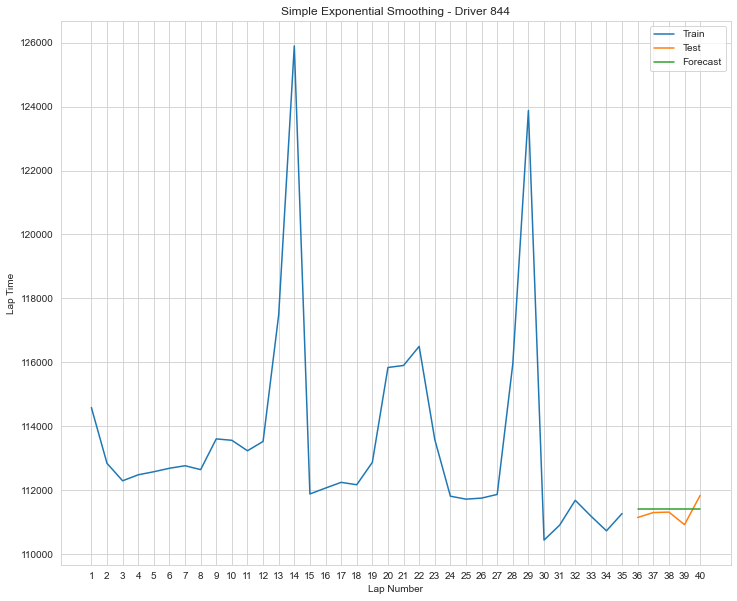

In [118]:
#plot the best model
data_train, data_test = train_test_split(data=df_844_belgian23.milliseconds, window_width=best_window_width)

plt.plot(data_train, label='Train')
plt.plot(data_test, label='Test')
plt.plot(best_forecast, label='Forecast')
plt.title('Simple Exponential Smoothing - Driver 844')
# ticks = plt.xticks(df_max_belgian23.index) 
ticks = plt.xticks(data_train.index.append(data_test.index))
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time') 
legend = plt.legend(loc='best')
plt.show()

>**Conclusions**: Alpha=0.4, Window-Width=35, Best RMSE=324.08 , MAPE=0.0026.

<h3><a id="arimax-gs-844">ARIMAX - Driver 844</a></h3>

In [224]:
def build_model_arimax(X,window_width, p, d, q):
    # prepare training dataset
    data_train, data_test = train_test_split(data=X, window_width=window_width)
    
    # train & forecast
    model = SARIMAX(data_train.milliseconds, 
              order=(p,d,q), 
              seasonal_order=(0,0,0,0),
                exog=data_train['pitted']).fit()
    
    
    # Ensure the exog data for prediction matches the forecast steps
    exog_test = data_test[['pitted']].iloc[:len(data_test)]

    #forecast on test
    yhat = model.predict(data_train.index.max(), (data_test.index.max()-1),exog=pd.DataFrame(data_test.pitted))
  
    rmse = np.sqrt(mean_squared_error(data_test.milliseconds, yhat)).round(2)
    mape = np.round(np.mean(np.abs(data_test.milliseconds-yhat)/data_test.milliseconds),4)
    
    #store results
    store_results(model_name='ARIMAX-GS-844', window_width=window_width, params= f"p={p} | d={d} | q={q}", rmse=rmse, mape=mape)
    
    return rmse, mape, yhat


#Grid search
def grid_search(dataset,window_widths, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_params, best_window_width, best_forecast = float("inf"), None, None, pd.Series(dtype='float64') #captures best score & config
    
    for window_width in window_widths:
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:           
                        rmse, mape, forecast = build_model_arimax(dataset,window_width,p,d,q)
                        if rmse < best_score:
                            best_score, best_params, best_window_width, best_forecast = rmse, f"p={p} | d={d} | q={q}", window_width, forecast
                    except Exception as e:
                        continue
    
    print("Best Params ", best_params, " Best RMSE ", best_score, " Window-Width ", best_window_width)
    return best_score, best_params, best_window_width, best_forecast

# grid search parameters
p_values = [1,2,3,4,15]
d_values = [0,1,2]
q_values = [1,2,3,4,5,15]
window_widths = [30, 35]

best_score, best_params, best_window_width, best_forecast =  grid_search(df_844_belgian23, window_widths, p_values, d_values, q_values)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-p

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Ana

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-p

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Ana

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\s

Best Params  p=4 | d=1 | q=15  Best RMSE  263.82  Window-Width  35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [225]:
#first 10 rows in results
results[results.Model=='ARIMAX-GS-844'].sort_values('RMSE').head(10)

,Model,Window_width,Model Parameters,RMSE,MAPE
937,ARIMAX-GS-844,35,p=4 | d=1 | q=15,263.8200,0.0027
952,ARIMAX-GS-844,35,p=15 | d=1 | q=3,264.6600,0.0040
950,ARIMAX-GS-844,35,p=15 | d=1 | q=1,266.4700,0.0036
883,ARIMAX-GS-844,35,p=1 | d=1 | q=15,279.0800,0.0029
919,ARIMAX-GS-844,35,p=3 | d=1 | q=15,280.4900,0.0030
951,ARIMAX-GS-844,35,p=15 | d=1 | q=2,281.3800,0.0040
878,ARIMAX-GS-844,35,p=1 | d=1 | q=1,303.8900,0.0012
882,ARIMAX-GS-844,35,p=1 | d=1 | q=5,304.6400,0.0012
916,ARIMAX-GS-844,35,p=3 | d=1 | q=3,305.5000,0.0012
881,ARIMAX-GS-844,35,p=1 | d=1 | q=4,305.5700,0.0012


In [226]:
results[results.Model=='ARIMAX-GS-844'].describe()

,RMSE,MAPE
count,186.0000,186.0000
mean,9367.3061,0.0846
std,15987.5395,0.1481
min,263.8200,0.0012
25%,1179.7900,0.0093
50%,3407.8950,0.0324
75%,8110.1400,0.0656
max,103275.2900,0.9496


Text(0.5, 1.0, 'ARIMAX - Driver 844')

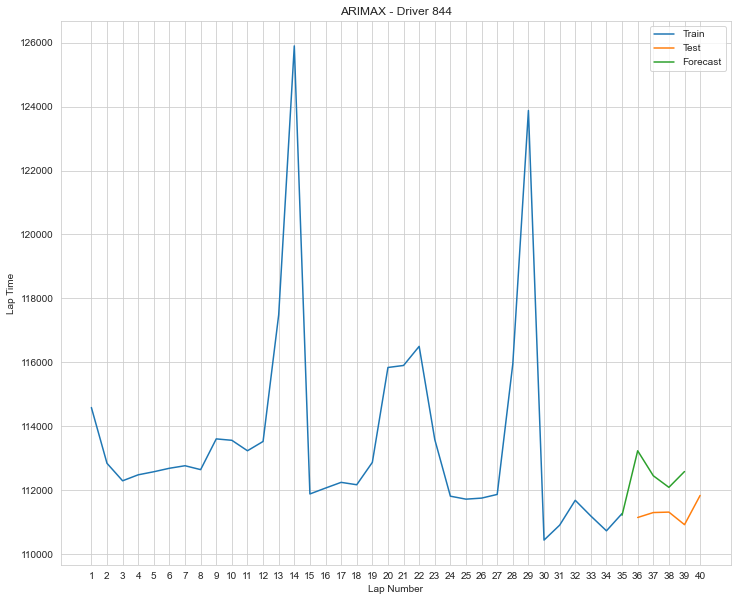

In [122]:
#plot the best model
data_train, data_test = train_test_split(data=df_844_belgian23, window_width=best_window_width)

plt.plot(data_train.milliseconds, label='Train')
plt.plot(data_test.milliseconds, label='Test')
plt.plot(best_forecast, label='Forecast')
plt.title('ARIMAX - Driver 844')
# ticks = plt.xticks(df_max_belgian23.index) 
ticks = plt.xticks(data_train.index.append(data_test.index))
xlabel = plt.xlabel('Lap Number') 
ylabel = plt.ylabel('Lap Time') 
legend = plt.legend(loc='best')
plt.show()

>**Conclusions**: 
The best model for Driver 844 is ARIMAX(4,1,15) with window width of 35 has RMSE of 263.8200 and MAPE=0.0027 and is better than the SES model by RMSE of ~100 ms. Clearly, the models that work for Verstappen works for Driver 844. 

> There have got to be many explanatory variables that determine the lap times for all drivers and they must be common between drivers such as say friction coefficient of a track, caution periods, need for pit stops etc. It may be worth building out a longitudinal dataset with as many explanatory variables from car telemtry and other sources to see if we can forecast the lap times better including pit stops over especially in a walk-forward forecast model. 

<h2><a id="ideas">Ideas for Improvement</a></h2>

- Remove pit stops prior to forecasting, if business objectives allow 


- Grid Search with Look Forward Forecast


- Cross-Validation


- Look under the hood - additional hyperparameters, dig into theory


- Explore other algorithms - LSTM, VAR, Random Forest, ensembles


- Base forecasts on real-time explanatory variables (longitudinal data)


<h2><a id="retired-models">Retired Models</a></h2>
Models that I tried for the sake of being thorough but which neither helped nor were aligned to the time series characteristics to begin with.

<h3><a id="ma">Simple Moving Average Forecast</a></h3>
I don't believe this will help, but just in the interest of being thorough

In [123]:
# #train-test split will be different for SMA
# train_size=35 
# data_train = df_max_belgian23[:train_size]
# data_test = df_max_belgian23[train_size:]

# # y = df_max_belgian23.copy()
# # ma_window = 5 #5 lap rolling window

In [124]:
# y['sma_forecast'] = df_max_belgian23.milliseconds.rolling(ma_window).mean()
# y['sma_forecast'][train_size:] = y['sma_forecast'][train_size-1] #We're doing this because the assumption is that we're 
# #...given the training dataset only and asked to forecast for the time period of the test dataset. We're not suppose to have
# #... access to the test dataset. We only use the test dataset for comparison.

In [125]:
# #plot train, test & forecast
# plt.plot(data_train.milliseconds, label='Train')
# plt.plot(data_test.milliseconds, label='Test')
# plt.plot(y.sma_forecast, label='Forecast')
# plt.title('Moving Average Forecast')
# plt.legend(loc='best')
# plt.show()

In [126]:
# #Errors in Moving Avg Forecast

# mse = mean_squared_error(data_test.milliseconds, y.sma_forecast[train_size:]).round(2)
# rmse = np.sqrt(mse).round(2)
# mape = np.round(np.mean(np.abs(data_test.milliseconds-y.sma_forecast[train_size:])/data_test.milliseconds),2)

# results.loc[results.shape[0]] = ['Moving Avg', rmse,mape]
# results

<h3><a id="sar">Simple Autoregression</a></h3>
Auto correlation is with the 15th lag only so AR may not be a good idea but it's worth trying. Let's use Simple AR as a baseline.

In [127]:
# #train model 
# # model = ARIMA(train_data_boxcox_diff, order=(1,0,0)).fit() 
# model = ARIMA(data_train.milliseconds, order=(14,0,0)).fit() #In simple AR model, we set the lag order to 1 only
# model.summary()

# y_hat = pd.DataFrame()
# y_hat['sar_forecast'] = model.predict(data_train.index.max(), (data_test.index.max()-1))
# # y_hat['sar_forecast'] = model.predict(data_train.index.max(), (data_test.index.max()-1)
# # y_hat['sar_forecast'] = model.forecast(data_test.shape[0]+1) #Forecast for next 24 months

In [128]:
# y_hat['sar_forecast']

In [129]:
# #plot train, test & forecast
# plt.plot(data_train.milliseconds, label='Train')
# plt.plot(data_test.milliseconds, label='Test')
# plt.plot(y_hat['sar_forecast'], label='Forecast')
# ticks = plt.xticks(df_max_belgian23.index) 
# xlabel = plt.xlabel('Lap Number') 
# ylabel = plt.ylabel('Lap Time') 
# title = plt.title('Simple Auto Regressive Model')
# legend = plt.legend(loc='best')
# plt.show()

In [130]:
# #Errors in Simple Exponential Smoothing

# mse = mean_squared_error(data_test.milliseconds, y_hat['sar_forecast']).round(2)
# rmse = np.sqrt(mse).round(2)
# mape = np.round(np.mean(np.abs(data_test.milliseconds-y_hat['sar_forecast'])/data_test.milliseconds),2)

# # Append results to the DataFrame
# # if 'sar_forecast' not in results['Model'].values:
# #     print("Updating error...")
# #     results.loc[results.shape[0]] = ['Simple AR', rmse, mape]
# # else:
# #     print("Error updating error!")

# results.loc[results.shape[0]] = ['Simple AR', rmse, mape]
# results

>**Observation**: The model just got worse. Lag order (p) of 14 gives us a MAPE of 4% and RMSE of 4887.57 milliseconds whereas lag order 1 produced the same result of 2% MAPE and RMSE of 2121.35. **Lag order 15 wouldn't coverge.**

>**Observation**: These models are likely not working because pit stops are not seasonal in nature, they are a result of an an external discretionary action so we have to include the pit stop strategy in the model assuming that the race team stuck to the pit stop strategy they created before the start of the race

<h3><a id="arma">ARMA</a></h3>

In [131]:
# #train model 
# # model = ARIMA(train_data_boxcox_diff, order=(1,0,0)).fit() 
# model = ARIMA(data_train.milliseconds, order=(1,0,1)).fit() #In simple AR model, we set the lag order to 1 only
# model.summary()

# y_hat['arma_forecast'] = model.predict(data_train.index.max(), (data_test.index.max()-1))


In [132]:
# y_hat['arma_forecast']

In [133]:
# #plot train, test & forecast
# plt.plot(data_train.milliseconds, label='Train')
# plt.plot(data_test.milliseconds, label='Test')
# plt.plot(y_hat['arma_forecast'], label='Forecast')
# ticks = plt.xticks(df_max_belgian23.index) 
# xlabel = plt.xlabel('Lap Number') 
# ylabel = plt.ylabel('Lap Time') 
# title = plt.title('ARMA Model')
# legend = plt.legend(loc='best')
# plt.show()

In [134]:
# #Errors in Simple Exponential Smoothing

# mse = mean_squared_error(data_test.milliseconds, y_hat['arma_forecast']).round(2)
# rmse = np.sqrt(mse).round(2)
# mape = np.round(np.mean(np.abs(data_test.milliseconds-y_hat['arma_forecast'])/data_test.milliseconds),2)

# # Append results to the DataFrame
# # if 'sar_forecast' not in results['Model'].values:
# #     print("Updating error...")
# #     results.loc[results.shape[0]] = ['Simple AR', rmse, mape]
# # else:
# #     print("Error updating error!")

# results.loc[results.shape[0]] = ['ARMA', rmse, mape]
# results

>**Observation**: ARMA(1,1) has same MAPE but slight improvement in RMSE of 2185.95 compared to AR(1). ARMA(1,2) did not converge.

<h3><a id="sarma">SARMA</a></h3>
Let's treat pit stops as being seasonal. We know they're not but let's see where this takes us.

In [135]:
# data_train.shape
# data_test.shape

>**Note**: Since ACF and PACF both show autocorrelation with 15th lag (only), let's set p&q parameters to 15 & 15.

In [136]:
# #ARIMAX(1,0,1)(0,0,0,0)
# model = SARIMAX(data_train.milliseconds, 
#               order=(2,0,2), 
#               seasonal_order=(1,1,1,15)).fit()
# model.summary()

>Event is the coefficient for exogneous variable (promo data), const is sigma2, ar.L1.y is coefficient of last observation (i.e. AR for 1st lag),  ma.L1.y is coefficient of last observation's forecast error (i.e. MA for 1st lag), ar.S.L12 is coefficient for 12th lag AR and ma.S.L12 is coefficient for 12th lag MA

In [137]:
# forecast_steps = len(data_test)
# print(f"Forecast steps: {forecast_steps}")

# # Ensure the exog data for prediction matches the forecast steps
# exog_test = data_test[['pitted']].iloc[:forecast_steps]

# #forecast on test
# y_hat = pd.DataFrame()
# y_hat['sarma_forecast'] = model.predict(data_train.index.max(), (data_test.index.max()-1))

# #transform forecast to add back variance/seasonality
# # y_hat_sarimax['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox']) #Add back seasonality

In [138]:
#fixes some formatting issues that cause problems with matplotlib
# y_hat.arimax_forecast.index = data.index[1:]

In [139]:
# y_hat['sarma_forecast']

In [140]:
# #plot train, test & forecast
# plt.plot(data_train.milliseconds, label='Train')
# plt.plot(data_test.milliseconds, label='Test')
# plt.plot(y_hat['sarma_forecast'], label='Forecast')
# # ylim = plt.ylim(df_max_belgian23.milliseconds.min() - 50000, df_max_belgian23.milliseconds.max() + 50000)
# plt.title('SARMAX Regressive Model')
# plt.legend(loc='best')
# plt.show()

In [141]:
# #Errors 
# mse = mean_squared_error(data_test.milliseconds, y_hat['sarma_forecast']).round(2)
# rmse = np.sqrt(mse).round(2)
# mape = np.round(np.mean(np.abs(data_test.milliseconds-y_hat['sarma_forecast'])/data_test.milliseconds),2)

# # Append errors to results
# results.loc[results.shape[0]] = ['SARMA', rmse, mape]
# results

<h3><a id=arima>ARIMA</a></h3>

In [142]:
# #train model 
# model = ARIMA(data_train.milliseconds, order=(1,1,1)).fit()
# model.summary()

# y_hat['arima_forecast'] = model.predict(data_train.index.max(), (data_test.index.max()))
# # y_hat['sar_forecast'] = model.predict(data_train.index.max(), (data_test.index.max()-1)
# # y_hat['sar_forecast'] = model.forecast(data_test.shape[0]+1) #Forecast for next 24 months

In [143]:
# y_hat['arima_forecast']

In [144]:
# #ARIMA's output - cumsum is opposite of differencing Adding back value of 1st row
# y_hat['arima_forecast'] = y_hat['arima_forecast'].cumsum().add(data_train.milliseconds[1]) 

In [145]:
# #plot train, test & forecast
# plt.plot(data_train.milliseconds, label='Train')
# plt.plot(data_test.milliseconds, label='Test')
# plt.plot(y_hat['arima_forecast'], label='Forecast')
# ticks = plt.xticks(df_max_belgian23.index) 
# xlabel = plt.xlabel('Lap Number') 
# ylabel = plt.ylabel('Lap Time') 
# title = plt.title('ARIMA Model')
# legend = plt.legend(loc='best')
# plt.show()

In [146]:
# y_hat['arima_forecast']

In [147]:
# #Error Calculations

# mse = mean_squared_error(data_test.milliseconds, y_hat['arima_forecast']).round(2)
# rmse = np.sqrt(mse).round(2)
# mape = np.round(np.mean(np.abs(data_test.milliseconds-y_hat['arima_forecast'])/data_test.milliseconds),2)

# # Append results to the DataFrame
# # if 'sar_forecast' not in results['Model'].values:
# #     print("Updating error...")
# #     results.loc[results.shape[0]] = ['Simple AR', rmse, mape]
# # else:
# #     print("Error updating error!")

# results.loc[results.shape[0]] = ['ARIMA', rmse, mape]
# results

>**Note**: I was playing around with ARIMA to see if differencing helps in any way, but it does not. Moreoever, I had earlier tried running a differenced train & test data set through Simple AR and Statsmodel told me pretty explicitly that the data is non-stationary which is a result of differencing a stationary dataset to begin with. So let's not waste time working on Integrated models like ARIMA which internally run differencing.

<h3><a id="sarmax">SARMAX</a></h3>
This doesn't make sense reallity, but I'm trying it out. It'll inlcude pit stops as exog but also account for seasonality.

In [148]:
# #ARIMAX(1,0,1)(0,0,0,0)
# model = SARIMAX(data_train.milliseconds, 
#               order=(1,0,1), 
#               seasonal_order=(1,1,1,15),
#                 exog=data_train['pitted']).fit()
# model.summary()

>Event is the coefficient for exogneous variable (promo data), const is sigma2, ar.L1.y is coefficient of last observation (i.e. AR for 1st lag),  ma.L1.y is coefficient of last observation's forecast error (i.e. MA for 1st lag), ar.S.L12 is coefficient for 12th lag AR and ma.S.L12 is coefficient for 12th lag MA

In [149]:
# forecast_steps = len(data_test)
# print(f"Forecast steps: {forecast_steps}")

# # Ensure the exog data for prediction matches the forecast steps
# exog_test = data_test[['pitted']].iloc[:forecast_steps]

# #forecast on test
# y_hat = pd.DataFrame()
# y_hat['sarmax_forecast'] = model.predict(data_train.index.max(), (data_test.index.max()-1),exog=pd.DataFrame(data_test.pitted))

# #transform forecast to add back variance/seasonality
# # y_hat_sarimax['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox']) #Add back seasonality

In [150]:
#fixes some formatting issues that cause problems with matplotlib
# y_hat.arimax_forecast.index = data.index[1:]

In [151]:
# y_hat['sarmax_forecast']

In [152]:
# #plot train, test & forecast
# plt.plot(data_train.milliseconds, label='Train')
# plt.plot(data_test.milliseconds, label='Test')
# plt.plot(y_hat['sarmax_forecast'], label='Forecast')
# # ylim = plt.ylim(df_max_belgian23.milliseconds.min() - 50000, df_max_belgian23.milliseconds.max() + 50000)
# plt.title('SARMAX Regressive Model')
# plt.legend(loc='best')
# plt.show()

In [153]:
# #Errors 
# mse = mean_squared_error(data_test.milliseconds, y_hat['sarmax_forecast']).round(2)
# rmse = np.sqrt(mse).round(2)
# mape = np.round(np.mean(np.abs(data_test.milliseconds-y_hat['sarmax_forecast'])/data_test.milliseconds),2)

# # Append errors to results
# results.loc[results.shape[0]] = ['SARMAX', rmse, mape]
# results

<h2><a id="references">References</a></h2>

<h3><a id="references-f1">Formula One</a></h3>
Resources for learning about Formula One

- <a href="https://f1miamigp.com/news/press-release/beginners-guide-formula-1/">F1 Basics</a>


- <a href="https://motorsporttickets.com/blog/how-many-laps-does-each-formula-1-race-have/">Laps in F1</a>


- <a href="https://www.youtube.com/watch?v=Q-jjZMMxbZs">What is F1</a>


- <a href="https://www.formula1.com/en/latest/article/drivers-teams-cars-circuits-and-more-everything-you-need-to-know-about.7iQfL3Rivf1comzdqV5jwc">F1 Summary</a>


- <a href="https://www.formula1.com/en/latest/article/the-beginners-guide-to-the-f1-drivers-championship.53MjXJzTDxQnfxfoCLnxNZ">F1 Beginner's Guide</a>


- <a href="https://en.wikipedia.org/wiki/List_of_Formula_One_driver_records">F1 Driver Records</a>


- <a href="https://en.wikipedia.org/wiki/List_of_Formula_One_seasons">Count of F1 Races</a>


- <a href="https://en.wikipedia.org/wiki/Safety_car#:~:text=In%20Formula%20One%20if%20an,in%20question%20entering%20the%20track">Safety Car</a>


- <a href="https://www.autosport.com/f1/news/what-do-the-different-colour-flags-mean-in-f1-everything-to-know-about-the-10-flags/10583727/#:~:text=A%20yellow%20and%20red%20flag,the%20tyre's%20grip%20could%20change">Safety Flags</a>


- <a href="https://www.dive-bomb.com/post/formula-one-stop-is-limited-strategy-to-blame-for-f1-s-boring-start-to-2023-opinion">Pit Stops Strategy</a>


- <a href="https://www.gpfans.com/en/f1-news/1010929/f1-pit-stops/#:~:text=Pit%20stops%20are%20mandatory%20in,tyre%20compounds%20during%20the%20race">Pit stop Basics</a>


- <a href="https://en.wikipedia.org/wiki/2023_Belgian_Grand_Prix">Belgian Grand Prix 2023 Race Wiki</a>


- <a href="https://www.formula1.com/en/latest/article/verstappen-charges-to-belgian-gp-win-as-red-bull-bag-1-2-finish.40AcUp3Pc8WMkmETKkngxo">Belgian Grand Prix 2023 Race Report 1</a>


- <a href="https://www.redbull.com/ca-en/belgian-f1-grand-prix-2023-race-report">Belgian Grand Prix 2023 Race Report 2</a>


- <a href="https://rtrsports.com/en/blog/the-strategy-in-formula-1-between-pit-stop-decisions-and-pilot-calls/">Race Strategy</a>

<h3><a id="references-ts">Time Series</a></h3>
Learnings resources for Time Series

- Data Analysis for Business, Economics, and Policy (1st ed.) (2021). Gábor Békés, Gábor Kézdi


- Forecasting: Principles and Practice (3rd ed.) (2021). Rob J Hyndman, George Athanasopoulos